# Library Import

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.neighbors import BallTree
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error
from typing import Type
import optuna

# Data Load

In [2]:
# train, test 데이터 불러오기
data_path: str = "~/house/data"
train_data: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv"))
test_data: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv"))
sample_submission: pd.DataFrame = pd.read_csv(os.path.join(data_path, "sample_submission.csv"))

In [3]:
# 금리, 지하철, 학교, 공원 정보 불러오기
interest_data: pd.DataFrame = pd.read_csv(os.path.join(data_path, "interestRate.csv"))
subway_data: pd.DataFrame = pd.read_csv(os.path.join(data_path, "subwayInfo.csv"))
school_data: pd.DataFrame = pd.read_csv(os.path.join(data_path, "schoolinfo.csv"))
park_data: pd.DataFrame = pd.read_csv(os.path.join(data_path, "parkInfo.csv"))

# Data Merge

## 1. 금리 데이터 병합
* `interest_data`: 2018년 12월 ~ 2024년 5월까지의 금리
* 계약 연월 기준으로 `interest_data`를 `train_data`로 병합 (2019년 4월 ~ 2023년 12월)
* 계약 연월 기준으로 `interest_data`를 `test_data`로 병합 (2024년 1월 ~ 2024년 6월)

In [4]:
train_data

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit
0,0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,17000.0
1,1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,23000.0
2,2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,23000.0
3,3,59.3400,201907,15,2,1,1986,36.964647,127.055847,33,5000.0
4,4,59.8100,201904,12,2,6,1995,36.972390,127.084514,24,1800.0
...,...,...,...,...,...,...,...,...,...,...,...
1801223,1801223,114.8126,202311,25,0,5,2010,37.528394,126.659398,13,39000.0
1801224,1801224,101.9088,202311,28,0,6,2010,37.528394,126.659398,13,38000.0
1801225,1801225,114.7900,202312,3,0,19,2010,37.528394,126.659398,13,37000.0
1801226,1801226,101.9088,202312,4,1,15,2010,37.528394,126.659398,13,34400.0


In [5]:
test_data

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age
0,0,84.9610,202404,12,1,14,2016,36.965423,127.048779,8
1,1,59.9000,202404,13,0,4,1997,36.963105,127.040678,27
2,2,39.2700,202404,29,0,5,1990,36.957089,127.047449,34
3,3,39.2700,202405,3,0,1,1990,36.957089,127.047449,34
4,4,46.9800,202406,2,0,4,1990,36.957089,127.047449,34
...,...,...,...,...,...,...,...,...,...,...
150167,150167,115.5101,202402,27,0,17,2010,37.528394,126.659398,14
150168,150168,142.8738,202403,2,0,4,2010,37.528394,126.659398,14
150169,150169,142.8738,202403,16,1,13,2010,37.528394,126.659398,14
150170,150170,114.9285,202403,22,1,2,2010,37.528394,126.659398,14


In [6]:
interest_data

,year_month,interest_rate
0,202405,3.56
1,202404,3.54
2,202403,3.59
3,202402,3.62
4,202401,3.66
...,...,...
61,201904,1.85
62,201903,1.94
63,201902,1.92
64,201901,1.99


In [7]:
# 계약 연월 기준으로 interest_data를 train_data로 병합
merged_train = pd.merge(train_data, interest_data, left_on="contract_year_month", right_on="year_month", how="left")
merged_train = merged_train.drop(columns=["year_month"])
merged_train

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit,interest_rate
0,0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,17000.0,1.78
1,1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,23000.0,1.26
2,2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,23000.0,1.26
3,3,59.3400,201907,15,2,1,1986,36.964647,127.055847,33,5000.0,1.68
4,4,59.8100,201904,12,2,6,1995,36.972390,127.084514,24,1800.0,1.85
...,...,...,...,...,...,...,...,...,...,...,...,...
1801223,1801223,114.8126,202311,25,0,5,2010,37.528394,126.659398,13,39000.0,4.00
1801224,1801224,101.9088,202311,28,0,6,2010,37.528394,126.659398,13,38000.0,4.00
1801225,1801225,114.7900,202312,3,0,19,2010,37.528394,126.659398,13,37000.0,3.84
1801226,1801226,101.9088,202312,4,1,15,2010,37.528394,126.659398,13,34400.0,3.84


In [8]:
# 계약 연월 기준으로 interest_data를 test_data로 병합
merged_test = pd.merge(test_data, interest_data, left_on="contract_year_month", right_on="year_month", how="left")
merged_test = merged_test.drop(columns=["year_month"])
merged_test

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,interest_rate
0,0,84.9610,202404,12,1,14,2016,36.965423,127.048779,8,3.54
1,1,59.9000,202404,13,0,4,1997,36.963105,127.040678,27,3.54
2,2,39.2700,202404,29,0,5,1990,36.957089,127.047449,34,3.54
3,3,39.2700,202405,3,0,1,1990,36.957089,127.047449,34,3.56
4,4,46.9800,202406,2,0,4,1990,36.957089,127.047449,34,NaN
...,...,...,...,...,...,...,...,...,...,...,...
150167,150167,115.5101,202402,27,0,17,2010,37.528394,126.659398,14,3.62
150168,150168,142.8738,202403,2,0,4,2010,37.528394,126.659398,14,3.59
150169,150169,142.8738,202403,16,1,13,2010,37.528394,126.659398,14,3.59
150170,150170,114.9285,202403,22,1,2,2010,37.528394,126.659398,14,3.59


In [9]:
# 금리 결측치 개수 확인 (2024년 6월)
merged_test[merged_test["interest_rate"].isnull()]["contract_year_month"].value_counts()

contract_year_month
202406    11882
Name: count, dtype: int64

## 2. 최단거리 데이터 병합

### sklearn의 BallTree를 활용한 haversine 거리 계산 함수

In [10]:
# 건물-공공장소 사이의 최단거리 장소를 반환하는 함수 정의
def find_closest_distance_haversine(
    train_data: pd.DataFrame, 
    loc_df: pd.DataFrame
) -> pd.DataFrame:
    """건물과 지하철/학교/공원 사이의 최단 haversine 거리와 위치 정보를 반환하는 함수

    Args:
        train_data (pd.DataFrame): 학습(훈련) 또는 테스트 데이터프레임
        loc_df (pd.DataFrame): 위도, 경도를 column으로 갖는 데이터프레임

    Returns:
        pd.DataFrame: index, 위도, 경도, 최단 haversine 거리를 column으로 갖는 데이터프레임
    """
    # degree -> radian 값으로 변환 (for 삼각함수)
    train_coords = np.radians(train_data[["latitude", "longitude"]].values)
    loc_coords = np.radians(loc_df[["latitude", "longitude"]].values)
    
    # Ball Tree 생성 
    tree = BallTree(loc_coords, metric="haversine")

    distances, indices = tree.query(train_coords, k=1) # 가까운 1 지점만 
    distances_meter = distances * 6371000 # 단위를 meter로 변환

    closest_coords = loc_df[["latitude", "longitude"]].iloc[indices.flatten()].values # 가까운 지점 좌표

    # index, 최단거리, 최단거리에 해당하는 지점의 위도, 경도로 이루어진 데이터프레임 생성
    result_df = pd.DataFrame({
        "index" : train_data.index,
        "closest_distance" : distances_meter.flatten(),
        "closest_latitude" : closest_coords[:, 0],
        "closest_longtitude" : closest_coords[:, 1]
    })

    return result_df

### subway 병합

In [11]:
subway_result = find_closest_distance_haversine(train_data, subway_data)
subway_result.columns = ["index", "nearest_subway_distance", "nearest_subway_latitude", "nearest_subway_longtitude"]
train_data = pd.merge(train_data, subway_result, on="index")

In [12]:
subway_result = find_closest_distance_haversine(test_data, subway_data)
subway_result.columns = ["index", "nearest_subway_distance", "nearest_subway_latitude", "nearest_subway_longtitude"]
test_data = pd.merge(test_data, subway_result, on="index")

### school 병합

In [13]:
school_result = find_closest_distance_haversine(train_data, school_data)
school_result.columns = ["index", "nearest_school_distance", "nearest_school_latitude", "nearest_school_longtitude"]
train_data = pd.merge(train_data, school_result, on="index")

In [14]:
school_result = find_closest_distance_haversine(test_data, school_data)
school_result.columns = ["index", "nearest_school_distance", "nearest_school_latitude", "nearest_school_longtitude"]
test_data = pd.merge(test_data, school_result, on="index")

### park 병합

In [15]:
park_result = find_closest_distance_haversine(train_data, park_data)
park_result.columns = ["index", "nearest_park_distance", "nearest_park_latitude", "nearest_park_longtitude"]
train_data = pd.merge(train_data, park_result, on="index")

In [16]:
park_result = find_closest_distance_haversine(test_data, park_data)
park_result.columns = ["index", "nearest_park_distance", "nearest_park_latitude", "nearest_park_longtitude"]
test_data = pd.merge(test_data, park_result, on="index")

## 3. 데이터 병합 결과 확인

In [17]:
on = merged_train.columns.drop("interest_rate").tolist() # 병합 기준이 될 column 리스트
train_data = pd.merge(merged_train, train_data, on=on, how="left")
# train_data = train_data.drop(columns=["index"])
train_data

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,...,interest_rate,nearest_subway_distance,nearest_subway_latitude,nearest_subway_longtitude,nearest_school_distance,nearest_school_latitude,nearest_school_longtitude,nearest_park_distance,nearest_park_latitude,nearest_park_longtitude
0,0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,...,1.78,716.952948,37.056496,127.052819,156.120431,37.053232,127.046337,498.618918,37.051333,127.041019
1,1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,...,1.26,716.952948,37.056496,127.052819,156.120431,37.053232,127.046337,498.618918,37.051333,127.041019
2,2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,...,1.26,716.952948,37.056496,127.052819,156.120431,37.053232,127.046337,498.618918,37.051333,127.041019
3,3,59.3400,201907,15,2,1,1986,36.964647,127.055847,33,...,1.68,3897.279708,36.990726,127.085159,214.559689,36.962943,127.056980,169.839678,36.963502,127.054582
4,4,59.8100,201904,12,2,6,1995,36.972390,127.084514,24,...,1.85,2039.685349,36.990726,127.085159,1708.489263,36.987746,127.085154,382.401815,36.971743,127.088742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1801223,1801223,114.8126,202311,25,0,5,2010,37.528394,126.659398,13,...,4.00,1483.044562,37.524649,126.675539,224.754177,37.529291,126.657114,398.113485,37.528189,126.654891
1801224,1801224,101.9088,202311,28,0,6,2010,37.528394,126.659398,13,...,4.00,1483.044562,37.524649,126.675539,224.754177,37.529291,126.657114,398.113485,37.528189,126.654891
1801225,1801225,114.7900,202312,3,0,19,2010,37.528394,126.659398,13,...,3.84,1483.044562,37.524649,126.675539,224.754177,37.529291,126.657114,398.113485,37.528189,126.654891
1801226,1801226,101.9088,202312,4,1,15,2010,37.528394,126.659398,13,...,3.84,1483.044562,37.524649,126.675539,224.754177,37.529291,126.657114,398.113485,37.528189,126.654891


In [18]:
on = merged_test.columns.drop("interest_rate").tolist() # 병합 기준이 될 column 리스트
test_data = pd.merge(merged_test, test_data, on=on, how="left")
# test_data = test_data.drop(columns=["index"])
test_data

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,interest_rate,nearest_subway_distance,nearest_subway_latitude,nearest_subway_longtitude,nearest_school_distance,nearest_school_latitude,nearest_school_longtitude,nearest_park_distance,nearest_park_latitude,nearest_park_longtitude
0,0,84.9610,202404,12,1,14,2016,36.965423,127.048779,8,3.54,4284.771362,36.990726,127.085159,779.057020,36.962943,127.056980,288.442840,36.964653,127.045679
1,1,59.9000,202404,13,0,4,1997,36.963105,127.040678,27,3.54,5004.558790,36.990726,127.085159,1448.494091,36.962943,127.056980,153.733042,36.961730,127.040502
2,2,39.2700,202404,29,0,5,1990,36.957089,127.047449,34,3.54,5021.183886,36.990726,127.085159,808.416163,36.950687,127.051762,272.286038,36.959505,127.047945
3,3,39.2700,202405,3,0,1,1990,36.957089,127.047449,34,3.56,5021.183886,36.990726,127.085159,808.416163,36.950687,127.051762,272.286038,36.959505,127.047945
4,4,46.9800,202406,2,0,4,1990,36.957089,127.047449,34,NaN,5021.183886,36.990726,127.085159,808.416163,36.950687,127.051762,272.286038,36.959505,127.047945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150167,150167,115.5101,202402,27,0,17,2010,37.528394,126.659398,14,3.62,1483.044562,37.524649,126.675539,224.754177,37.529291,126.657114,398.113485,37.528189,126.654891
150168,150168,142.8738,202403,2,0,4,2010,37.528394,126.659398,14,3.59,1483.044562,37.524649,126.675539,224.754177,37.529291,126.657114,398.113485,37.528189,126.654891
150169,150169,142.8738,202403,16,1,13,2010,37.528394,126.659398,14,3.59,1483.044562,37.524649,126.675539,224.754177,37.529291,126.657114,398.113485,37.528189,126.654891
150170,150170,114.9285,202403,22,1,2,2010,37.528394,126.659398,14,3.59,1483.044562,37.524649,126.675539,224.754177,37.529291,126.657114,398.113485,37.528189,126.654891


# 이상치 탐지

In [19]:
# 이상치 탐지 함수 정의
def find_outliers(data: pd.Series) -> pd.Series:
    """안 울타리(inner fence) 밖에 있는 데이터(이상치, outlier)를 반환하는 함수

    Args:
        data (pd.Series): 이상치 탐지를 하고싶은 데이터의 column

    Returns:
        pd.Series: 이상치에 해당하는 데이터 Series 반환
    """
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data < lower_bound) | (data > upper_bound)]

# EDA

## 1. 기술통계량

### 1.1 train data

- **`area_m2`**: 면적 (제곱미터)  
- **`contract_year_month`**: 계약 연월  
- **`contract_day`**: 계약일  
- **`contract_type`**: 계약 유형 (0: 신규, 1: 갱신, 2: 모름)  
- **`floor`**: 층수  
- **`built_year`**: 건축 연도  
- **`latitude`**: 위도  
- **`longitude`**: 경도  
- **`age`**: 건물의 나이 (계산된 값)  
- **`deposit`**: 전세 실거래가 (타겟 변수)

- **참고**: 건물 나이(age) = 계약 연도(contract_year) - 건축 연도(built_year): 현 시점의 나이가 아니라 계약 시점의 나이!

In [20]:
# 건물 나이(age) = 계약 연도(contract_year) - 건축 연도(built_year): 현 시점의 나이가 아니라 계약 시점의 나이!
(train_data["age"] == (train_data["contract_year_month"] // 100) - train_data["built_year"]).value_counts()

True    1801228
Name: count, dtype: int64

In [21]:
# train_data 결측치 & 데이터 타입 확인
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1801228 entries, 0 to 1801227
Data columns (total 21 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   index                      int64  
 1   area_m2                    float64
 2   contract_year_month        int64  
 3   contract_day               int64  
 4   contract_type              int64  
 5   floor                      int64  
 6   built_year                 int64  
 7   latitude                   float64
 8   longitude                  float64
 9   age                        int64  
 10  deposit                    float64
 11  interest_rate              float64
 12  nearest_subway_distance    float64
 13  nearest_subway_latitude    float64
 14  nearest_subway_longtitude  float64
 15  nearest_school_distance    float64
 16  nearest_school_latitude    float64
 17  nearest_school_longtitude  float64
 18  nearest_park_distance      float64
 19  nearest_park_latitude      float64
 20  ne

In [22]:
# train data 기술통계량 확인
train_data.describe()

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,...,interest_rate,nearest_subway_distance,nearest_subway_latitude,nearest_subway_longtitude,nearest_school_distance,nearest_school_latitude,nearest_school_longtitude,nearest_park_distance,nearest_park_latitude,nearest_park_longtitude
count,1.801228e+06,1.801228e+06,1.801228e+06,1.801228e+06,1.801228e+06,1.801228e+06,1.801228e+06,1.801228e+06,1.801228e+06,1.801228e+06,...,1.801228e+06,1.801228e+06,1.801228e+06,1.801228e+06,1.801228e+06,1.801228e+06,1.801228e+06,1.801228e+06,1.801228e+06,1.801228e+06
mean,9.006135e+05,7.518833e+01,2.021331e+05,1.589943e+01,1.203805e+00,1.005197e+01,2.004199e+03,3.747721e+01,1.269662e+02,1.706597e+01,...,2.157603e+00,1.425348e+03,3.747642e+01,1.269655e+02,2.853427e+02,3.747720e+01,1.269663e+02,2.627288e+02,3.747720e+01,1.269662e+02
std,5.199699e+05,2.552632e+01,1.352815e+02,8.625998e+00,8.852792e-01,6.973359e+00,1.115132e+01,1.625113e-01,1.701221e-01,1.112796e+01,...,1.191301e+00,2.099354e+03,1.614451e-01,1.678358e-01,1.687514e+02,1.625282e-01,1.702002e-01,2.888939e+02,1.625303e-01,1.699954e-01
min,0.000000e+00,1.032150e+01,2.019040e+05,1.000000e+00,0.000000e+00,-4.000000e+00,1.961000e+03,3.691791e+01,1.264787e+02,-3.000000e+00,...,8.000000e-01,2.792850e+01,3.676950e+01,1.264938e+02,1.577725e+01,3.693849e+01,1.264799e+02,3.335847e-03,3.692440e+01,1.264804e+02
25%,4.503068e+05,5.975000e+01,2.020080e+05,9.000000e+00,0.000000e+00,5.000000e+00,1.995000e+03,3.737976e+01,1.268422e+02,7.000000e+00,...,1.060000e+00,4.367286e+02,3.738513e+01,1.268432e+02,1.768388e+02,3.738014e+01,1.268423e+02,1.303223e+02,3.737921e+01,1.268418e+02
50%,9.006135e+05,7.715000e+01,2.021110e+05,1.600000e+01,2.000000e+00,9.000000e+00,2.004000e+03,3.750227e+01,1.269976e+02,1.700000e+01,...,1.690000e+00,7.262881e+02,3.750421e+01,1.270112e+02,2.494304e+02,3.750202e+01,1.269970e+02,1.996585e+02,3.750164e+01,1.269974e+02
75%,1.350920e+06,8.496000e+01,2.022120e+05,2.300000e+01,2.000000e+00,1.400000e+01,2.015000e+03,3.758205e+01,1.270888e+02,2.600000e+01,...,3.560000e+00,1.437391e+03,3.758018e+01,1.270801e+02,3.516515e+02,3.758322e+01,1.270885e+02,3.068936e+02,3.758355e+01,1.270887e+02
max,1.801227e+06,3.173600e+02,2.023120e+05,3.100000e+01,2.000000e+00,6.800000e+01,2.024000e+03,3.818194e+01,1.276609e+02,6.200000e+01,...,4.340000e+00,2.628670e+04,3.794810e+01,1.276286e+02,3.399389e+03,3.818302e+01,1.276479e+02,7.820516e+03,3.818768e+01,1.276720e+02


#### 1.1.1 column별 종류, 개수 확인

In [23]:
# 면적 종류, 개수 확인
print("area(m2): ", train_data["area_m2"].sort_values().unique())
print("", len(train_data["area_m2"].sort_values().unique()))

area(m2):  [ 10.3215  10.78    10.92   ... 273.96   301.47   317.36  ]
 22281


In [24]:
# 계약 연월 종류, 개수 확인
print(train_data["contract_year_month"].sort_values().unique()) # 201904 ~ 202312
print(len(train_data["contract_year_month"].sort_values().unique()))

[201904 201905 201906 201907 201908 201909 201910 201911 201912 202001
 202002 202003 202004 202005 202006 202007 202008 202009 202010 202011
 202012 202101 202102 202103 202104 202105 202106 202107 202108 202109
 202110 202111 202112 202201 202202 202203 202204 202205 202206 202207
 202208 202209 202210 202211 202212 202301 202302 202303 202304 202305
 202306 202307 202308 202309 202310 202311 202312]
57


In [25]:
# 계약일 종류, 개수 확인
print(train_data["contract_day"].sort_values().unique())
print(len(train_data["contract_day"].sort_values().unique()))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
31


In [26]:
# 계약 유형 확인
print(train_data["contract_type"].value_counts())

contract_type
2    926786
0    559687
1    314755
Name: count, dtype: int64


In [27]:
# 층수 종류, 개수 확인
print("floor: ", train_data["floor"].sort_values().unique())  # -4층 ~ 0층을 어떻게 처리할지 고민해봐야 한다.
print("# of floor: ", len(train_data["floor"].sort_values().unique())) # -4층 ~ 68층까지 연속적인 층수

floor:  [-4 -3 -2 -1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19
 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43
 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67
 68]
# of floor:  73


In [28]:
# 층수가 음수인 건물 개수 확인
train_data["floor"].value_counts().sort_index()

floor
-4      1
-3      1
-2      8
-1     57
 0      3
       ..
 64     1
 65     2
 66     2
 67     1
 68     4
Name: count, Length: 73, dtype: int64

In [29]:
# 층수가 음수인 건물 확인
train_data[(train_data["built_year"] != 2024) & (train_data["floor"] <= 0)]

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,...,interest_rate,nearest_subway_distance,nearest_subway_latitude,nearest_subway_longtitude,nearest_school_distance,nearest_school_latitude,nearest_school_longtitude,nearest_park_distance,nearest_park_latitude,nearest_park_longtitude
99412,99412,84.90,201906,29,2,0,1992,37.374628,127.114846,27,...,1.78,428.054556,37.378455,127.114322,155.374386,37.375633,127.116068,178.834109,37.374582,127.116869
99413,99413,84.90,201906,29,2,0,1992,37.374628,127.114846,27,...,1.78,428.054556,37.378455,127.114322,155.374386,37.375633,127.116068,178.834109,37.374582,127.116869
99414,99414,84.90,201906,29,2,0,1992,37.374628,127.114846,27,...,1.78,428.054556,37.378455,127.114322,155.374386,37.375633,127.116068,178.834109,37.374582,127.116869
381997,381997,59.31,202107,19,0,-1,2000,37.593130,127.142876,21,...,0.95,1144.395057,37.603392,127.143869,318.077422,37.590459,127.141584,167.969198,37.592621,127.141082
935290,935290,84.96,202305,4,1,-1,2009,37.295999,127.153425,14,...,3.56,2496.661732,37.274917,127.143714,409.490357,37.294396,127.149257,92.417813,37.296157,127.152400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1549913,1549913,59.95,202304,8,0,-1,2000,37.550705,127.005566,23,...,3.44,326.880950,37.548013,127.007055,321.234216,37.553515,127.006415,46.138317,37.551108,127.005693
1563622,1563622,59.99,202304,11,2,-1,2001,37.550376,127.005442,22,...,3.44,298.761855,37.548013,127.007055,359.445046,37.553515,127.006415,84.381076,37.551108,127.005693
1565283,1565283,28.30,202305,10,0,-1,1974,37.534703,127.009230,49,...,3.56,586.299844,37.529430,127.009169,594.100079,37.539204,127.005600,287.481047,37.534508,127.012481
1590425,1590425,80.55,202312,19,0,-1,2003,37.614333,127.040002,20,...,3.84,883.969639,37.613292,127.030053,346.009927,37.611293,127.040841,236.770646,37.615257,127.037581


In [30]:
# 건축 연도 종류, 개수 확인
print("built year: ", train_data["built_year"].sort_values().unique()) # 1961년을 제외한 1965~2023년까지는 연속적인 연도 / 2024년은 훈련 데이터에서 제거해야 한다.
print("# of built year: ", len(train_data["built_year"].sort_values().unique()))

built year:  [1961 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977
 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991
 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019
 2020 2021 2022 2023 2024]
# of built year:  61


In [31]:
# 건물 나이 종류, 개수 확인
print("building age: ", train_data["age"].sort_values().unique()) # -3, -2, -1을 어떻게 처리할지 고민해봐야 한다. (가계약? -> 준공 전 계약)
print("# of building age: ", len(train_data["age"].sort_values().unique()))

building age:  [-3 -2 -1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20
 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44
 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62]
# of building age:  66


In [32]:
# 전세 실거래가 종류, 개수 확인
print("deposit: ", train_data["deposit"].sort_values().unique()) # -3, -2, -1을 어떻게 처리할지 고민해봐야 한다. (가계약? -> 준공 전 계약)
print("# of deposit: ", len(train_data["deposit"].sort_values().unique())) # 

deposit:  [3.0e+02 5.0e+02 6.0e+02 ... 9.5e+05 1.0e+06 1.1e+06]
# of deposit:  10445


In [33]:
# 건축 연도가 2024년인 데이터 수 확인: 총 97개
print(train_data.loc[train_data["built_year"] == 2024])

           index  area_m2  contract_year_month  contract_day  contract_type  \
445834    445834  84.9500               202109             7              0   
673476    673476  59.8007               202301             6              0   
841576    841576  59.8000               202312             8              0   
863548    863548  84.9500               202312            16              0   
863549    863549  74.9700               202312            18              0   
...          ...      ...                  ...           ...            ...   
1575792  1575792  59.7400               202311            28              0   
1575805  1575805  59.7400               202311            28              2   
1576183  1576183  59.7400               202312             5              0   
1576399  1576399  59.7400               202312             9              0   
1576448  1576448  59.7400               202312             9              0   

         floor  built_year   latitude   longitude  

In [34]:
# 건축 연도가 2024년인 건물 나이 확인: -3, -1
print("age built in 2024: ", train_data[train_data["built_year"] == 2024]["age"].unique())

age built in 2024:  [-3 -1]


In [35]:
# 건물의 나이가 음수인 건물의 건축 연도 확인 (2024년 제외)
age_year = train_data[(train_data["built_year"] != 2024) & (train_data["age"] < 0)]
age_year

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,...,interest_rate,nearest_subway_distance,nearest_subway_latitude,nearest_subway_longtitude,nearest_school_distance,nearest_school_latitude,nearest_school_longtitude,nearest_park_distance,nearest_park_latitude,nearest_park_longtitude
6101,6101,53.8100,201905,2,2,5,2021,37.690500,127.211147,-2,...,1.85,5078.676499,37.653225,127.244493,610.653135,37.695275,127.214576,658.625771,37.695142,127.206497
6102,6102,56.9600,201905,2,2,9,2021,37.690500,127.211147,-2,...,1.85,5078.676499,37.653225,127.244493,610.653135,37.695275,127.214576,658.625771,37.695142,127.206497
6103,6103,56.9600,201905,2,2,16,2021,37.690500,127.211147,-2,...,1.85,5078.676499,37.653225,127.244493,610.653135,37.695275,127.214576,658.625771,37.695142,127.206497
6104,6104,49.3400,201905,2,2,9,2021,37.690500,127.211147,-2,...,1.85,5078.676499,37.653225,127.244493,610.653135,37.695275,127.214576,658.625771,37.695142,127.206497
6106,6106,53.8100,201905,4,2,11,2021,37.690500,127.211147,-2,...,1.85,5078.676499,37.653225,127.244493,610.653135,37.695275,127.214576,658.625771,37.695142,127.206497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1766153,1766153,59.5224,202210,23,0,18,2023,37.593681,126.719239,-1,...,3.98,2862.181260,37.571462,126.735637,775.408967,37.587035,126.716576,704.299170,37.597861,126.725245
1766154,1766154,59.6074,202211,19,2,15,2023,37.593681,126.719239,-1,...,4.34,2862.181260,37.571462,126.735637,775.408967,37.587035,126.716576,704.299170,37.597861,126.725245
1766155,1766155,59.6074,202211,19,2,15,2023,37.593681,126.719239,-1,...,4.34,2862.181260,37.571462,126.735637,775.408967,37.587035,126.716576,704.299170,37.597861,126.725245
1766156,1766156,59.5224,202212,7,0,4,2023,37.593681,126.719239,-1,...,4.29,2862.181260,37.571462,126.735637,775.408967,37.587035,126.716576,704.299170,37.597861,126.725245


In [36]:
print("age: ", age_year["age"].sort_values().unique()) # 2024년 외에도 -3, -1 있는지 확인
print("built year: ", age_year["built_year"].sort_values().unique()) # 2024년 이외 건축연도 확인

age:  [-3 -2 -1]
built year:  [2020 2021 2022 2023]


- 나이가 음수인 건물은 
    - -3: 3개
    - -2: 28개
    - -1: 3323개
- 나이가 음수인 건물의 계약 연도는 2019년 5월 이후
- 나이가 음수인 건물은 건축 연도가 2020년 이후

In [37]:
age_year["deposit"].describe()

count      3354.000000
mean      51383.661896
std       28437.407188
min        4428.000000
25%       32000.000000
50%       43000.000000
75%       65000.000000
max      700000.000000
Name: deposit, dtype: float64

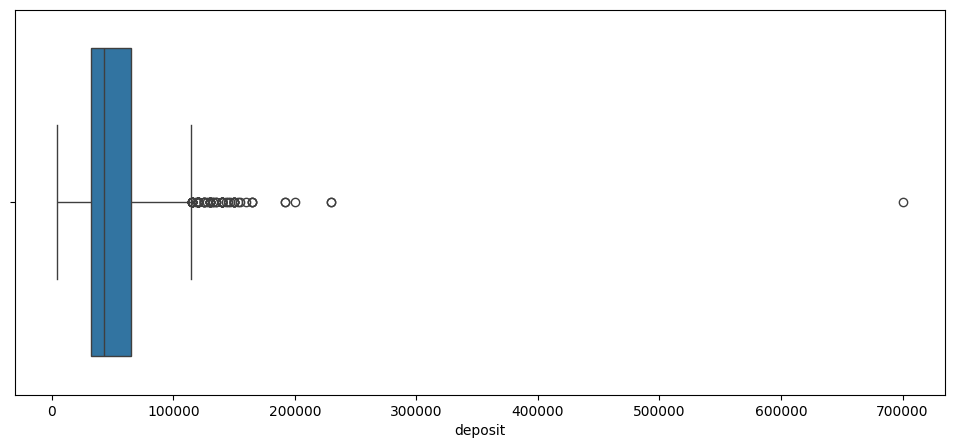

In [38]:
fig, ax =  plt.subplots(figsize=(12, 5))
sns.boxplot(data=age_year, x="deposit")
plt.show()

In [39]:
# 가장 큰 이상치 확인
age_year.loc[age_year["deposit"] == max(age_year["deposit"])]

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,...,interest_rate,nearest_subway_distance,nearest_subway_latitude,nearest_subway_longtitude,nearest_school_distance,nearest_school_latitude,nearest_school_longtitude,nearest_park_distance,nearest_park_latitude,nearest_park_longtitude
1344709,1344709,219.43,202111,25,0,2,2022,37.527616,127.047125,-1,...,1.55,581.834212,37.527381,127.040534,189.050942,37.528282,127.045153,373.603653,37.525154,127.044242


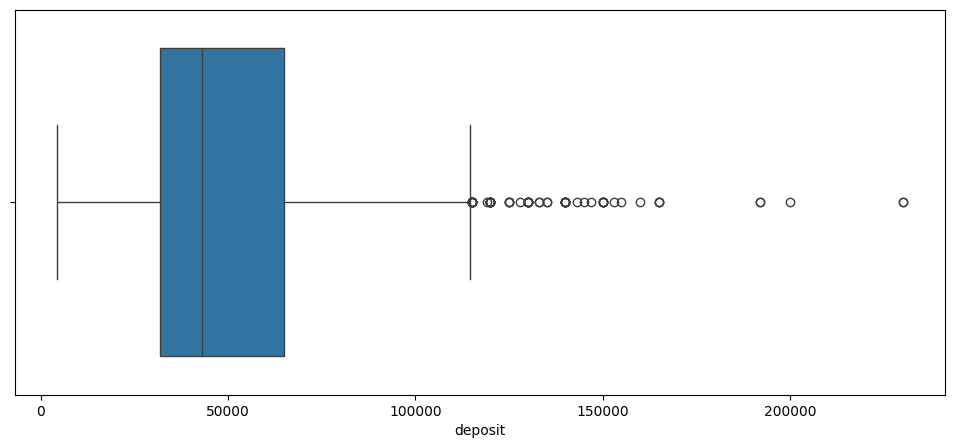

In [40]:
# 가장 큰 이상치 제거하고 boxplot
fig, ax =  plt.subplots(figsize=(12, 5))
sns.boxplot(x=age_year["deposit"].drop(1344709, axis=0))
plt.show()

In [41]:
# 건물의 나이가 음수인 건물의 계약, 건축 연도 확인 (2024년 제외)

print("contract year: ", (age_year["contract_year_month"]//100).unique())
print("built year", age_year["built_year"].unique())
print("age: ", age_year["age"].unique())

# age_year[["contract_year_month", "built_year", "age"]]
# grouped = age_year.groupby("age")
# for name, group in grouped:
#     print(name)
#     print(group)

contract year:  [2019 2020 2021 2022]
built year [2021 2020 2022 2023]
age:  [-2 -1 -3]


### 1.2 interest data

In [42]:
interest_data

,year_month,interest_rate
0,202405,3.56
1,202404,3.54
2,202403,3.59
3,202402,3.62
4,202401,3.66
...,...,...
61,201904,1.85
62,201903,1.94
63,201902,1.92
64,201901,1.99


In [43]:
# 금리 데이터 결측치 & 데이터 타입 확인
interest_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year_month     66 non-null     int64  
 1   interest_rate  66 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.2 KB


In [44]:
# 금리 데이터 기술통계량 확인
interest_data.describe()

,year_month,interest_rate
count,66.000000,66.000000
mean,202124.500000,2.180303
std,161.989197,1.172429
min,201812.000000,0.800000
25%,202004.250000,1.170000
50%,202108.500000,1.750000
75%,202278.750000,3.555000
max,202405.000000,4.340000


In [45]:
# 금리 연월 종류, 개수 확인 (나중에 계약 연월과 비교 위해)
print(interest_data["year_month"].sort_values().unique()) # 2018년 12월 ~ 2024년 5월
print(len(interest_data["year_month"].sort_values().unique()))

[201812 201901 201902 201903 201904 201905 201906 201907 201908 201909
 201910 201911 201912 202001 202002 202003 202004 202005 202006 202007
 202008 202009 202010 202011 202012 202101 202102 202103 202104 202105
 202106 202107 202108 202109 202110 202111 202112 202201 202202 202203
 202204 202205 202206 202207 202208 202209 202210 202211 202212 202301
 202302 202303 202304 202305 202306 202307 202308 202309 202310 202311
 202312 202401 202402 202403 202404 202405]
66


### 1.3 subway data

In [46]:
subway_data

,latitude,longitude
0,37.759380,127.042292
1,37.541021,126.971300
2,37.529849,126.964561
3,37.514219,126.942454
4,37.513342,126.926382
...,...,...
695,37.378384,126.645168
696,37.386007,126.639484
697,37.393054,126.634729
698,37.399907,126.630347


In [47]:
# 지하철 데이터 결측치 & 데이터 타입 확인
subway_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   700 non-null    float64
 1   longitude  700 non-null    float64
dtypes: float64(2)
memory usage: 11.1 KB


In [48]:
# 지하철 데이터 기술통계량 확인
subway_data.describe()

,latitude,longitude
count,700.000000,700.000000
mean,37.511467,126.979502
std,0.151368,0.181557
min,36.769502,126.476241
25%,37.474883,126.880270
50%,37.527585,127.007471
75%,37.579632,127.070794
max,37.948100,127.723792


### 1.4 school data

In [49]:
school_data

,schoolLevel,latitude,longitude
0,elementary,37.703889,127.540156
1,elementary,37.676874,127.600664
2,elementary,36.987340,129.399471
3,elementary,34.808753,126.456974
4,elementary,35.854580,127.003365
...,...,...,...
11987,high,36.108950,128.355632
11988,high,36.507932,126.621914
11989,elementary,37.493705,126.900119
11990,middle,35.214234,129.011813


In [50]:
# 학교 데이터 결측치 & 데이터 타입 확인
school_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11992 entries, 0 to 11991
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   schoolLevel  11992 non-null  object 
 1   latitude     11992 non-null  float64
 2   longitude    11992 non-null  float64
dtypes: float64(2), object(1)
memory usage: 281.2+ KB


In [51]:
# 학교 데이터 기술통계량 확인
school_data.describe(include="all")

,schoolLevel,latitude,longitude
count,11992,11992.000000,11992.000000
unique,3,NaN,NaN
top,elementary,NaN,NaN
freq,6316,NaN,NaN
mean,NaN,36.441643,127.548917
std,NaN,1.082630,0.869670
min,NaN,33.169187,124.661625
25%,NaN,35.505631,126.898965
50%,NaN,36.593296,127.151250
75%,NaN,37.471376,128.338716


In [52]:
# 학교 종류별 개수 확인
print(school_data["schoolLevel"].value_counts())
print(school_data["schoolLevel"].value_counts(normalize=True))

schoolLevel
elementary    6316
middle        3289
high          2387
Name: count, dtype: int64
schoolLevel
elementary    0.526684
middle        0.274266
high          0.199049
Name: proportion, dtype: float64


### 1.5 park data

In [53]:
park_data

,latitude,longitude,area
0,37.509628,127.628406,856.0
1,37.508443,127.627414,847.0
2,37.493844,127.509326,1276.0
3,37.496021,127.408216,3300.0
4,37.496164,127.412326,394.0
...,...,...,...
17559,35.834179,128.619666,2642.0
17560,35.832236,128.618209,2654.0
17561,35.834941,128.626945,3315.0
17562,35.822580,128.625316,2237.0


In [54]:
# 공원 데이터 결측치 & 데이터 타입 확인
park_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   17564 non-null  float64
 1   longitude  17564 non-null  float64
 2   area       17564 non-null  float64
dtypes: float64(3)
memory usage: 411.8 KB


In [55]:
# 공원 데이터 기술통계량 확인
park_data.describe()

,latitude,longitude,area
count,17564.000000,17564.000000,1.756400e+04
mean,36.537278,127.467183,3.104273e+04
std,1.025544,0.844644,2.020487e+05
min,31.373335,125.433012,0.000000e+00
25%,35.771576,126.872959,1.501225e+03
50%,36.810368,127.103294,2.240900e+03
75%,37.454903,128.067983,1.026325e+04
max,38.493170,137.202661,9.320660e+06


## 2. 데이터 시각화

### [Univariate]
### 2.1 Box Plot

#### 2.1.1 train data

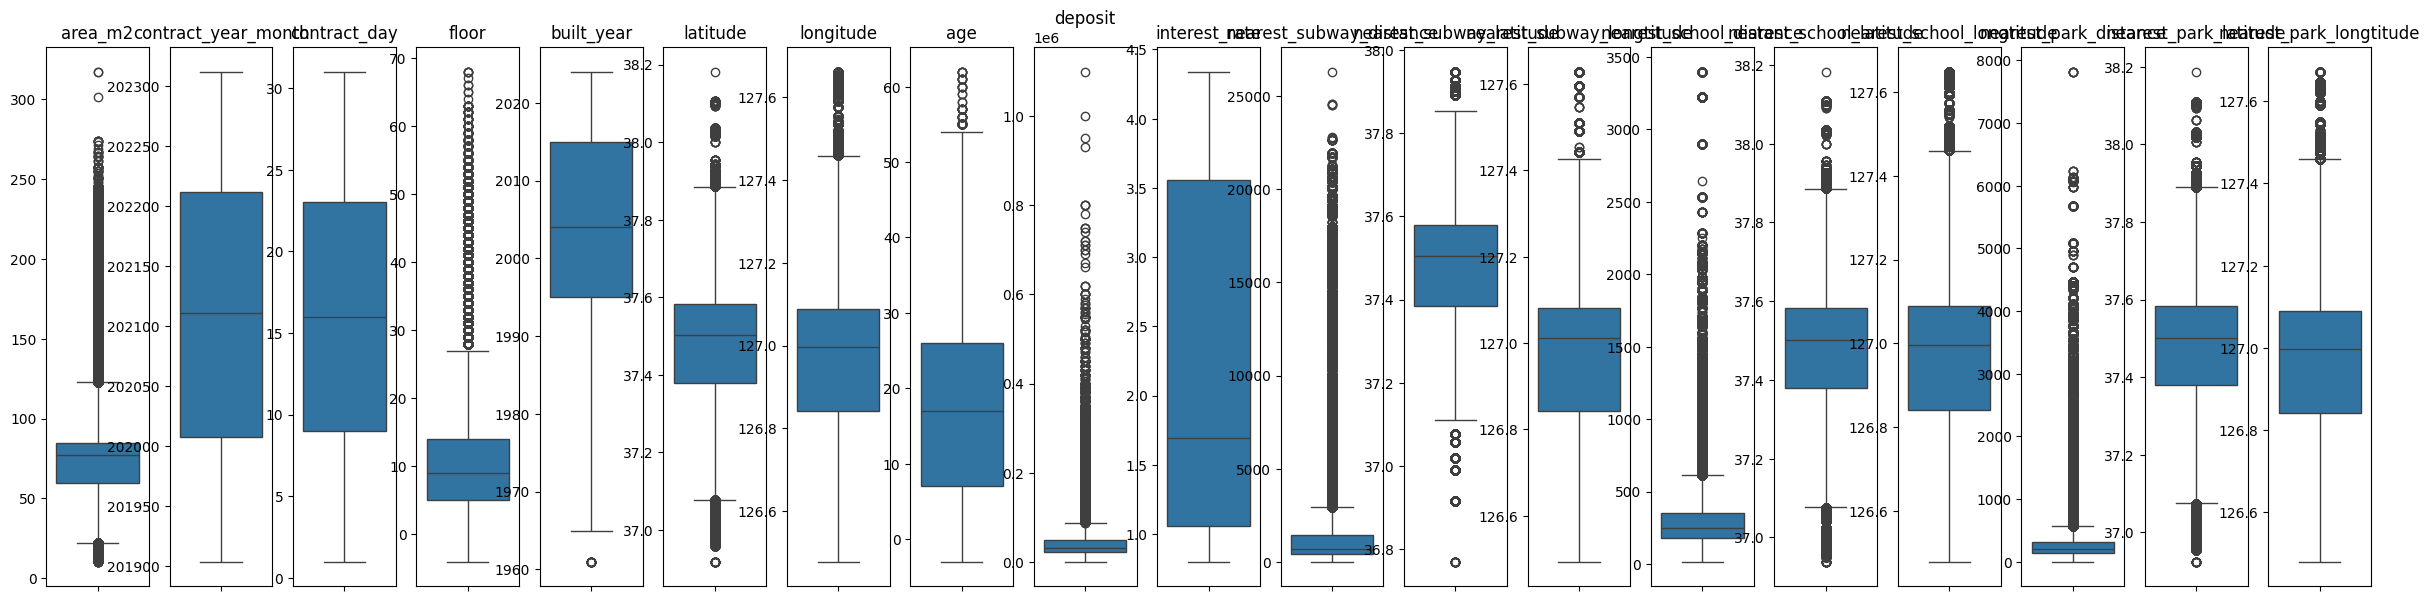

In [56]:
# train data 상자 그림 시각화 (인덱스, 계약 유형 제외)
fig, axes =  plt.subplots(1, train_data.drop(columns=["index", "contract_type"]).shape[1], figsize=(30, 7))

for idx, col in enumerate(train_data.drop(columns=["index", "contract_type"])):
    sns.boxplot(data=train_data.drop(columns=["index", "contract_type"]), y=col, ax=axes[idx])

    axes[idx].set_title(col)
    axes[idx].set_ylabel("")

plt.show()

만약 계약 유형별 feature들의 상자 그림이 궁금하다면?

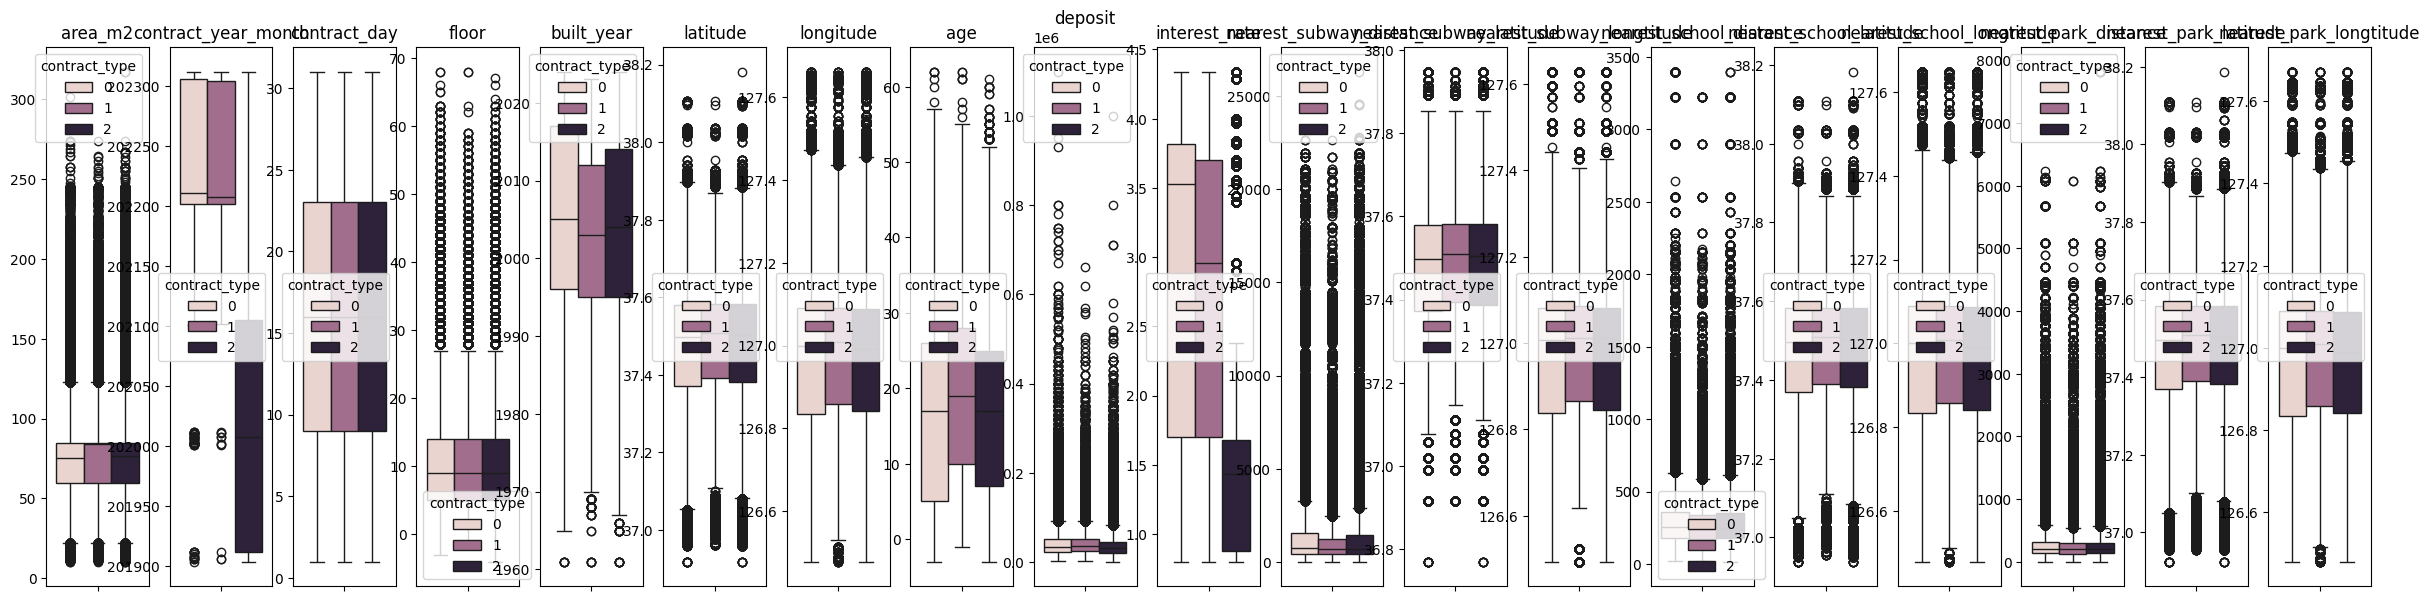

In [57]:
# train data 상자 그림 시각화 (인덱스, 계약 유형 제외)
fig, axes =  plt.subplots(1, train_data.drop(columns=["index", "contract_type"]).shape[1], figsize=(30, 7))

for idx, col in enumerate(train_data.drop(columns=["index", "contract_type"])):
    sns.boxplot(data=train_data.drop(columns=["index", "contract_type"]), y=col, ax=axes[idx],
                hue=train_data["contract_type"]
                )

    axes[idx].set_title(col)
    axes[idx].set_ylabel("")

plt.show()

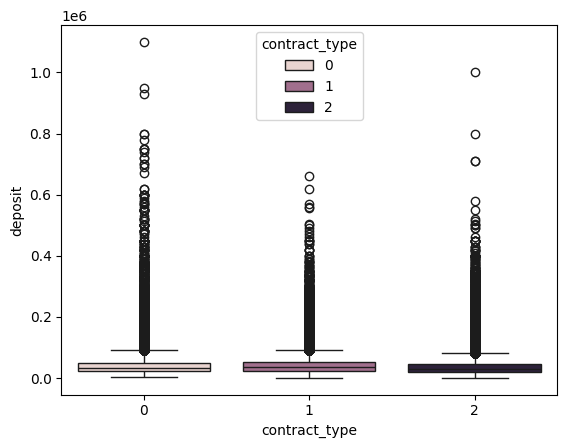

In [58]:
sns.boxplot(data=train_data, x="contract_type", y="deposit", hue="contract_type")
plt.show()

#### 2.1.2 interest data

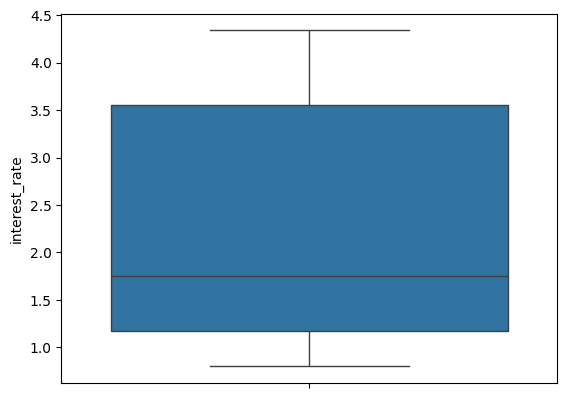

In [59]:
# 금리 상자 그림 시각화 (금리 연월 제외)
sns.boxplot(data=interest_data, y="interest_rate")
plt.show()

#### 2.1.3 subway data

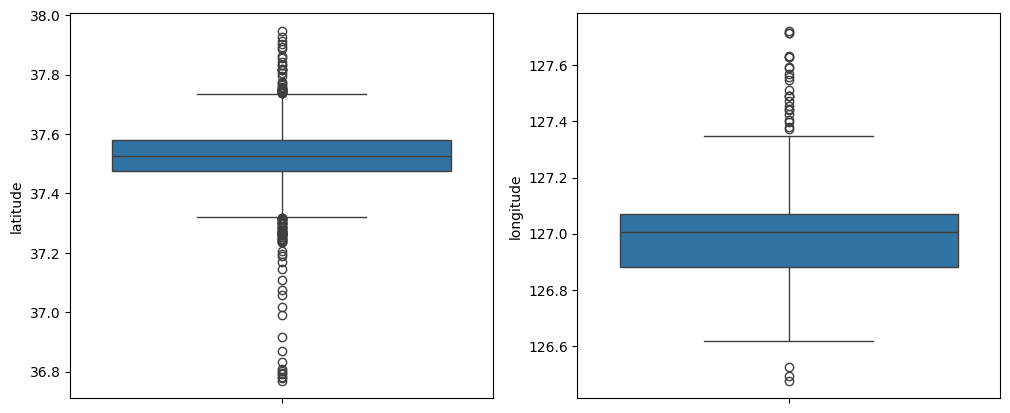

In [60]:
# 지하철 위도, 경도 상자 그림 시각화
fig, axes =  plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(data=subway_data, y="latitude", ax=axes[0])
sns.boxplot(data=subway_data, y="longitude", ax=axes[1])
plt.show()

#### 2.1.4 school data

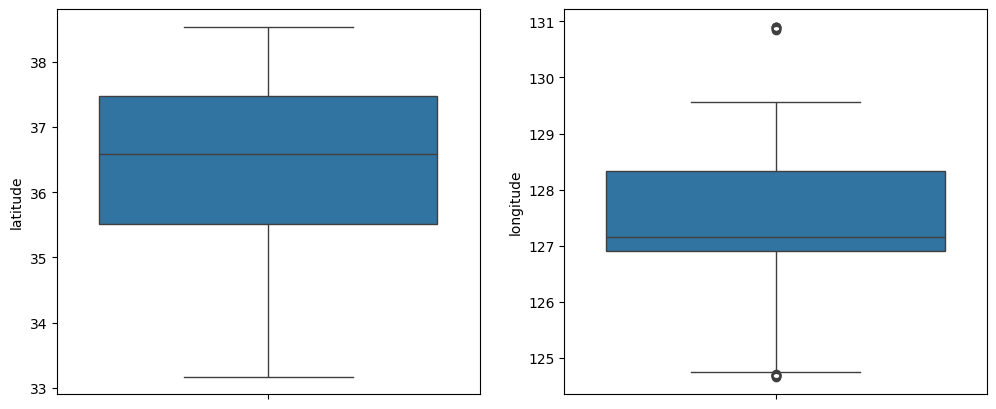

In [61]:
# 학교 위도, 경도 상자 그림 시각화
fig, axes =  plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(data=school_data, y="latitude", ax=axes[0])
sns.boxplot(data=school_data, y="longitude", ax=axes[1])
plt.show()

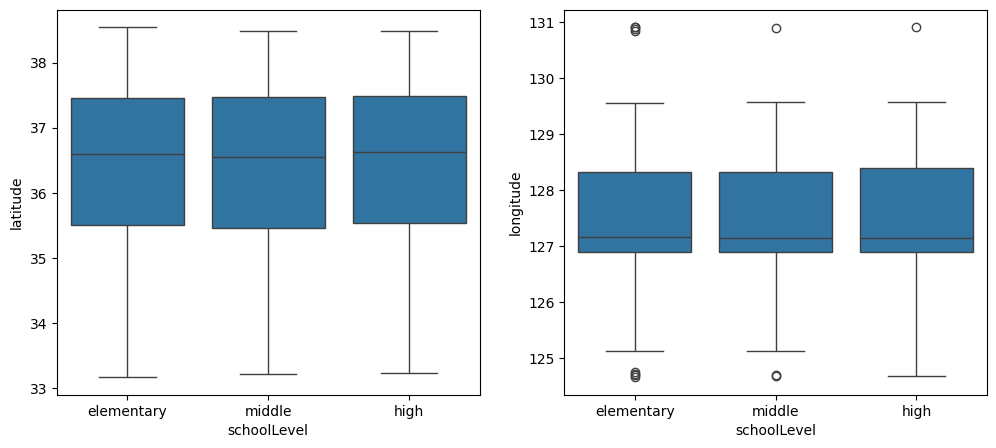

In [62]:
# 학교 레벨에 따른 위도, 경도 상자 그림 시각화
fig, axes =  plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(school_data, x="schoolLevel", y="latitude", ax=axes[0])
sns.boxplot(school_data, x="schoolLevel", y="longitude", ax=axes[1])
plt.show()

#### 2.1.5 park data

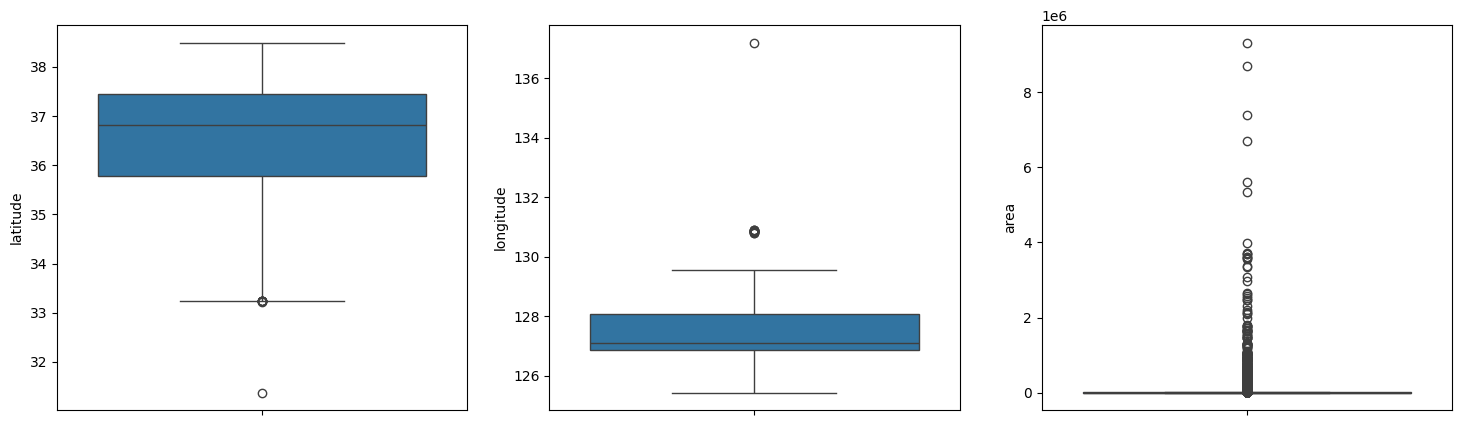

In [63]:
# 공원 위도, 경도, 면적 상자 그림 시각화 (금리 연월 제외)
fig, axes =  plt.subplots(1, 3, figsize=(18, 5))
sns.boxplot(data=park_data, y="latitude", ax=axes[0])
sns.boxplot(data=park_data, y="longitude", ax=axes[1])
sns.boxplot(data=park_data, y="area", ax=axes[2])
plt.show()

### 2.2 Histogram / Count Plot

#### 2.2.1 train data

##### 면적 분포

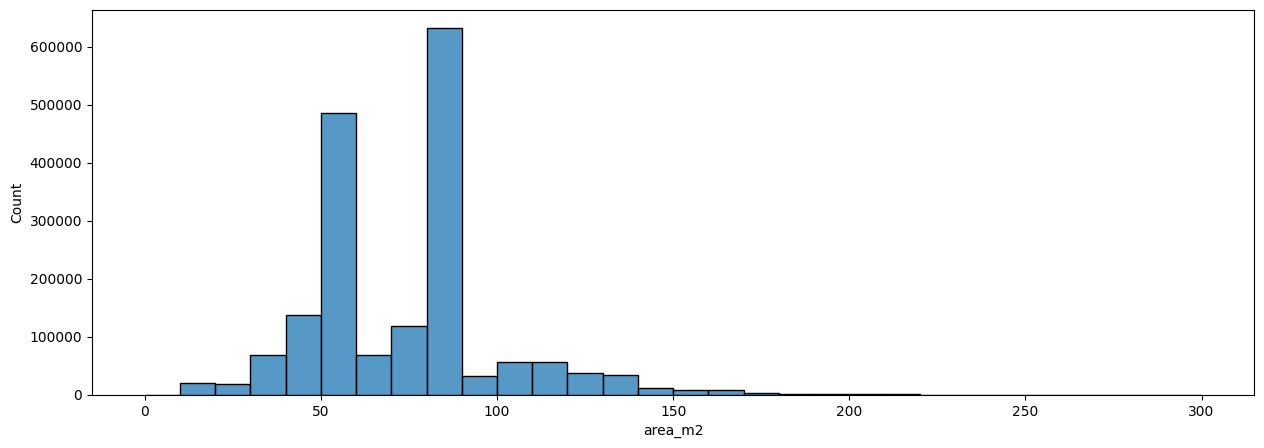

In [64]:
# 면적 히스토그램 시각화
fig, ax =  plt.subplots(figsize=(15, 5))
sns.histplot(data=train_data, x="area_m2", bins=np.arange(0, 310, 10))
plt.show()

##### 계약 연/월/일 분포

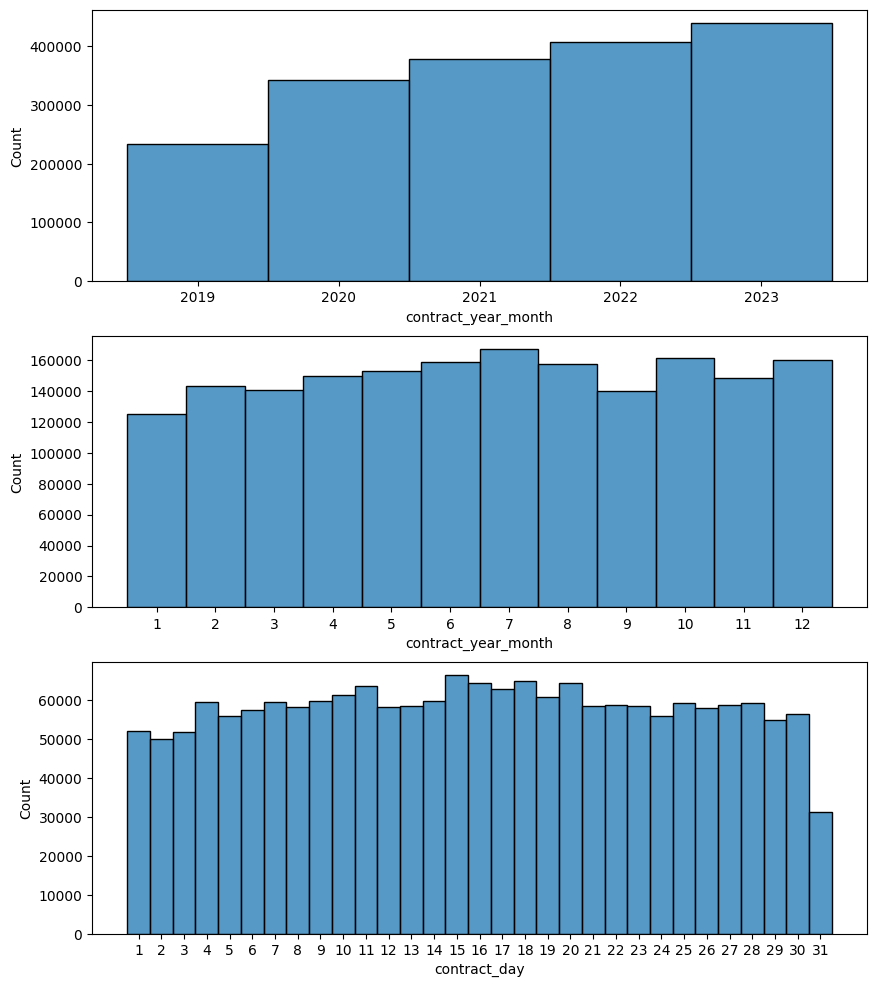

In [65]:
# 계약 연/월/일별 히스토그램 시각화
fig, axes =  plt.subplots(3, 1, figsize=(10, 12))

sns.histplot(x=(train_data["contract_year_month"] // 100).sort_values().astype(str), ax=axes[0])
sns.histplot(x=(train_data["contract_year_month"] % 100).sort_values().astype(str), ax=axes[1])
sns.histplot(x=train_data["contract_day"].sort_values().astype(str), ax=axes[2])
plt.show()

##### 계약 유형 분포

In [66]:
print(train_data["contract_type"].value_counts())
print(train_data["contract_type"].value_counts(normalize=True))

contract_type
2    926786
0    559687
1    314755
Name: count, dtype: int64
contract_type
2    0.514530
0    0.310725
1    0.174745
Name: proportion, dtype: float64


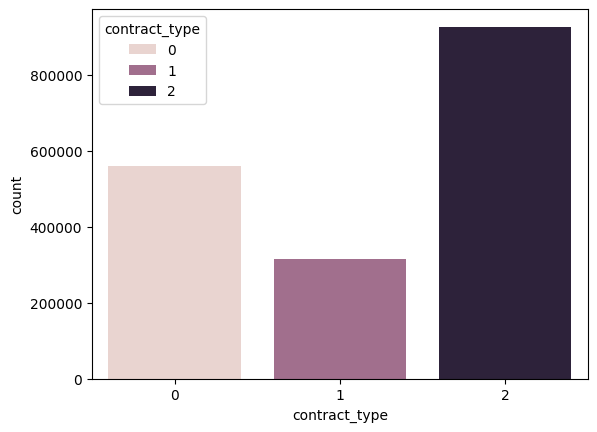

In [67]:
# 계약 유형별 빈도수 시각화
sns.countplot(data=train_data, x="contract_type", hue="contract_type")
plt.show()

##### 층수 분포

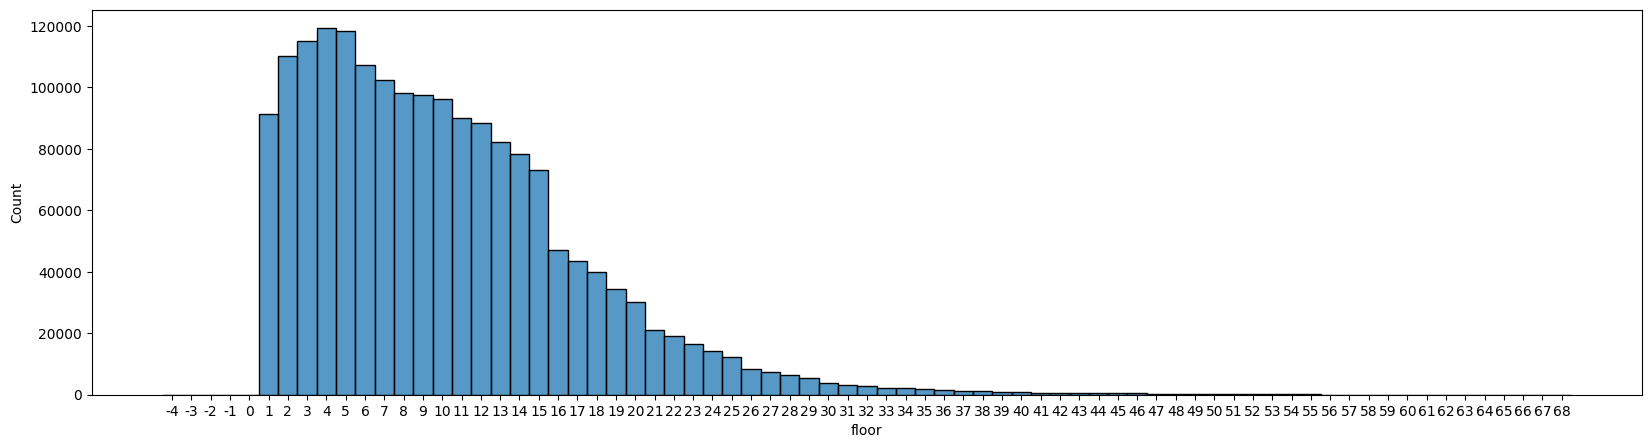

In [68]:
# 층수 히스토그램 시각화
fig, ax =  plt.subplots(figsize=(20, 5))
sns.histplot(train_data["floor"].sort_values().astype(str))#, kde=True)
plt.show()

##### 건축 연도 분포

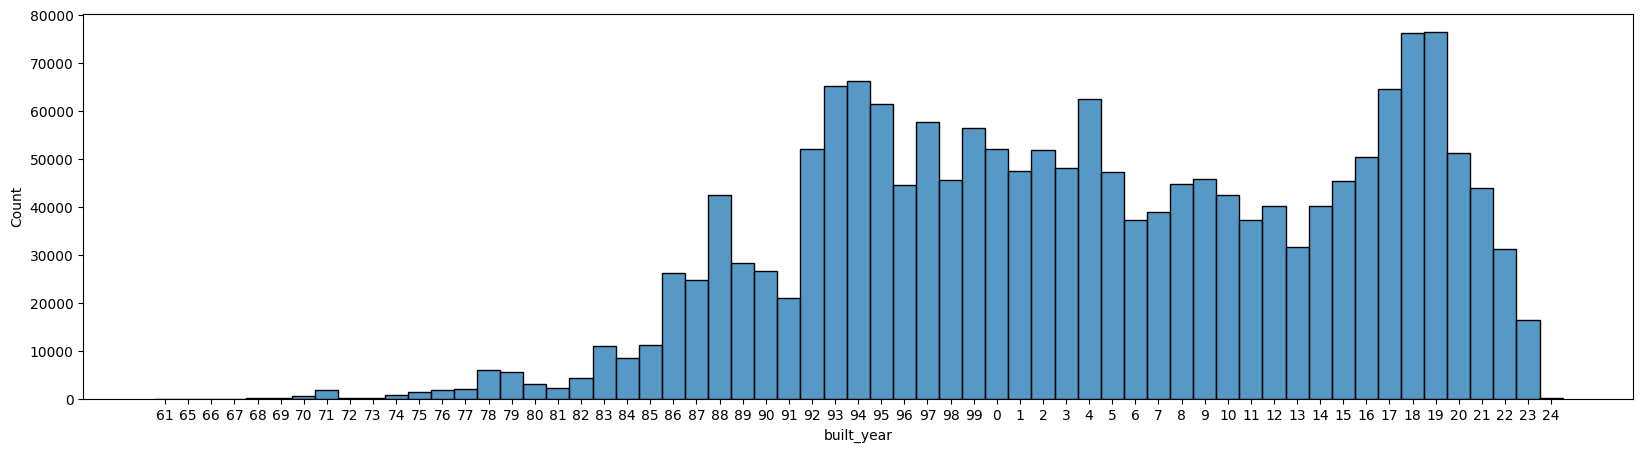

In [69]:
# 건축 연도 히스토그램 시각화
fig, ax =  plt.subplots(figsize=(20, 5))
sns.histplot((train_data["built_year"].sort_values() % 100).astype(str))#, kde=True)
plt.show()

##### 위도, 경도 분포

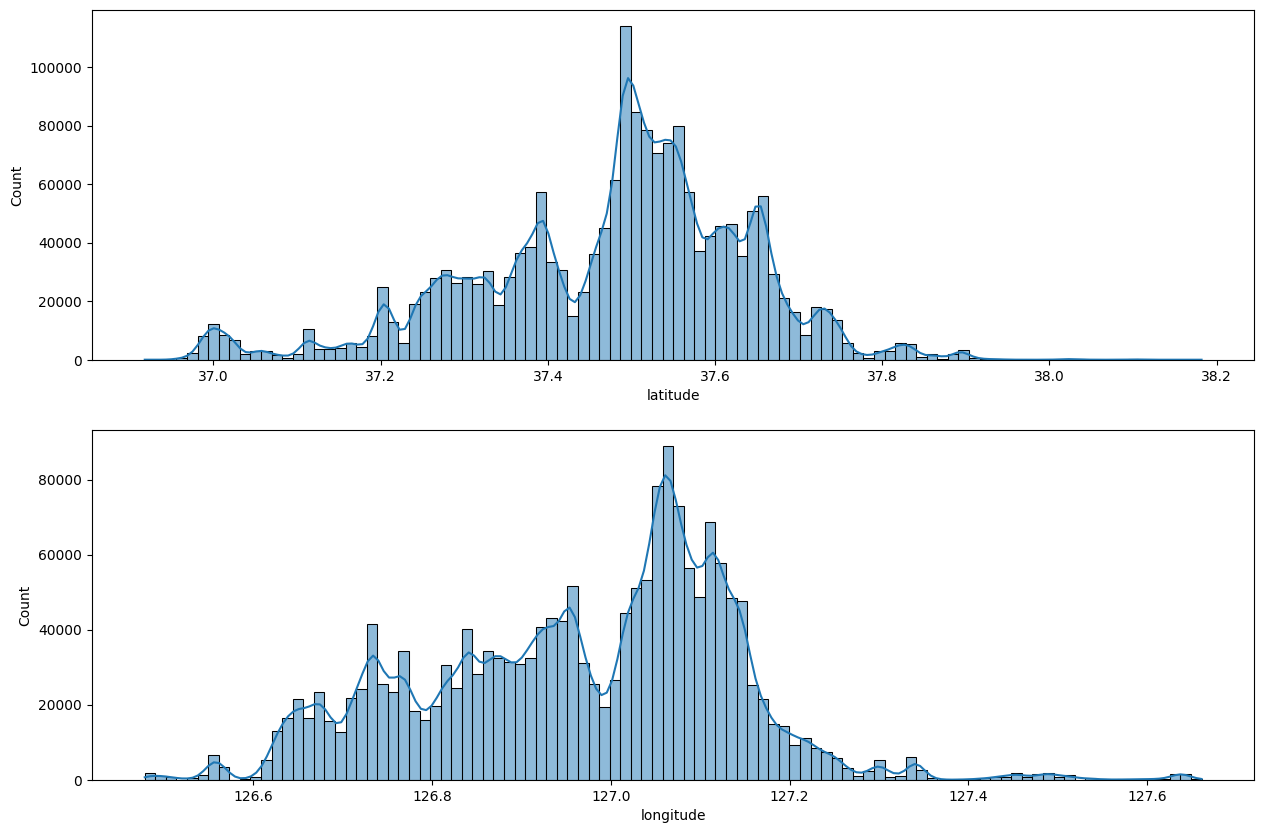

In [70]:
# 위도, 경도 히스토그램 시각화
fig, axes =  plt.subplots(2, 1, figsize=(15, 10))
sns.histplot(train_data["latitude"], kde=True, bins=100, ax=axes[0])
sns.histplot(train_data["longitude"], kde=True, bins=100, ax=axes[1])
plt.show()

##### 건물 나이 분포

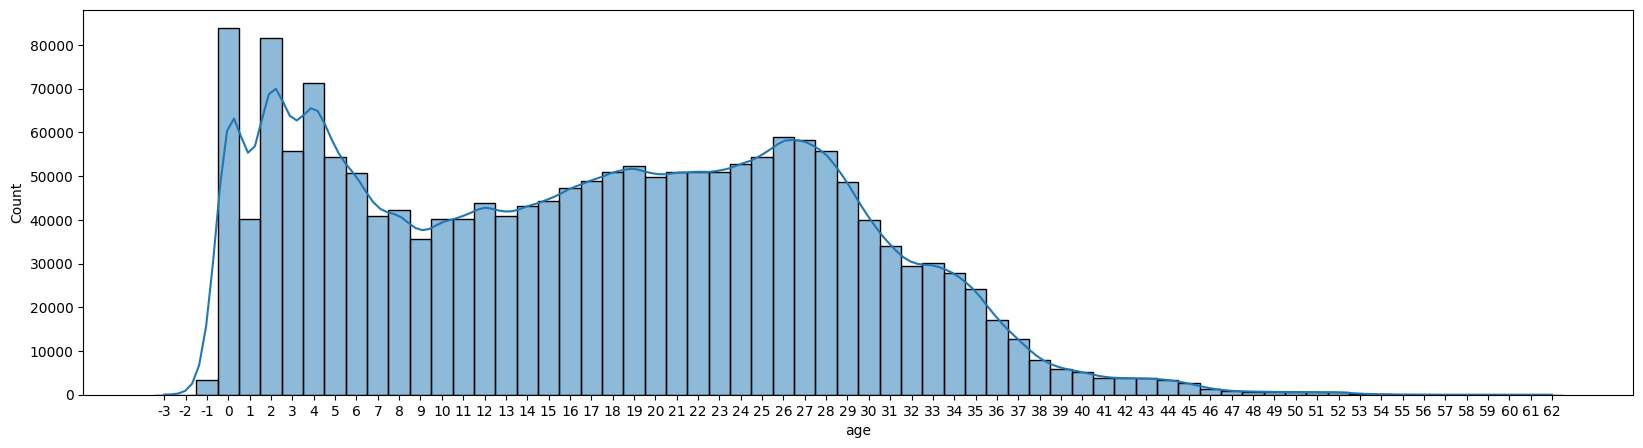

In [71]:
# 건물 나이 히스토그램 시각화
fig, ax =  plt.subplots(figsize=(20, 5))
sns.histplot(train_data["age"].sort_values().astype(str), kde=True)
plt.show()

##### 전세 실거래가 분포

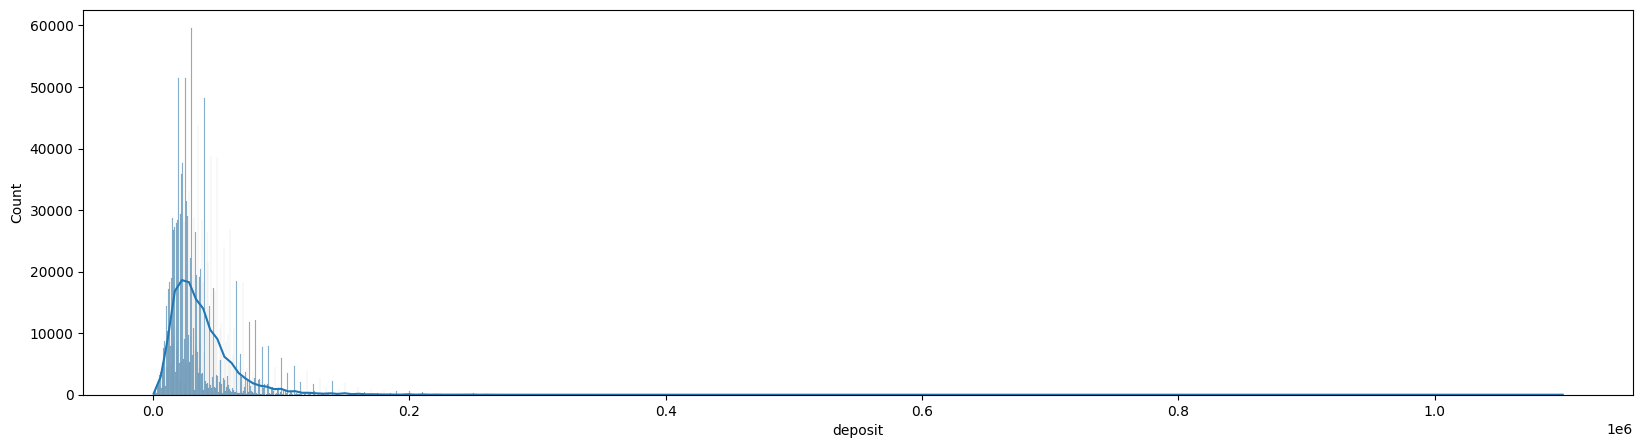

In [72]:
# 전세 실거래가 히스토그램 시각화
fig, ax = plt.subplots(figsize=(20, 5))
sns.histplot(data=train_data, x="deposit", kde=True)
plt.show()

#### 2.2.2 interest data

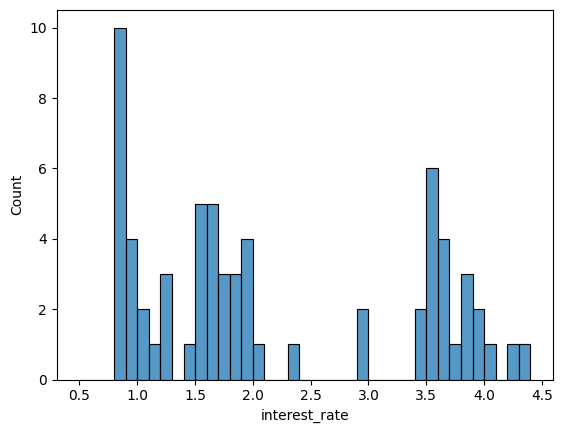

In [73]:
# 금리 히스토그램 시각화
sns.histplot(data=interest_data, x="interest_rate", bins=np.arange(0.5, 4.5, 0.1))
plt.show()

#### 2.2.3 subway data

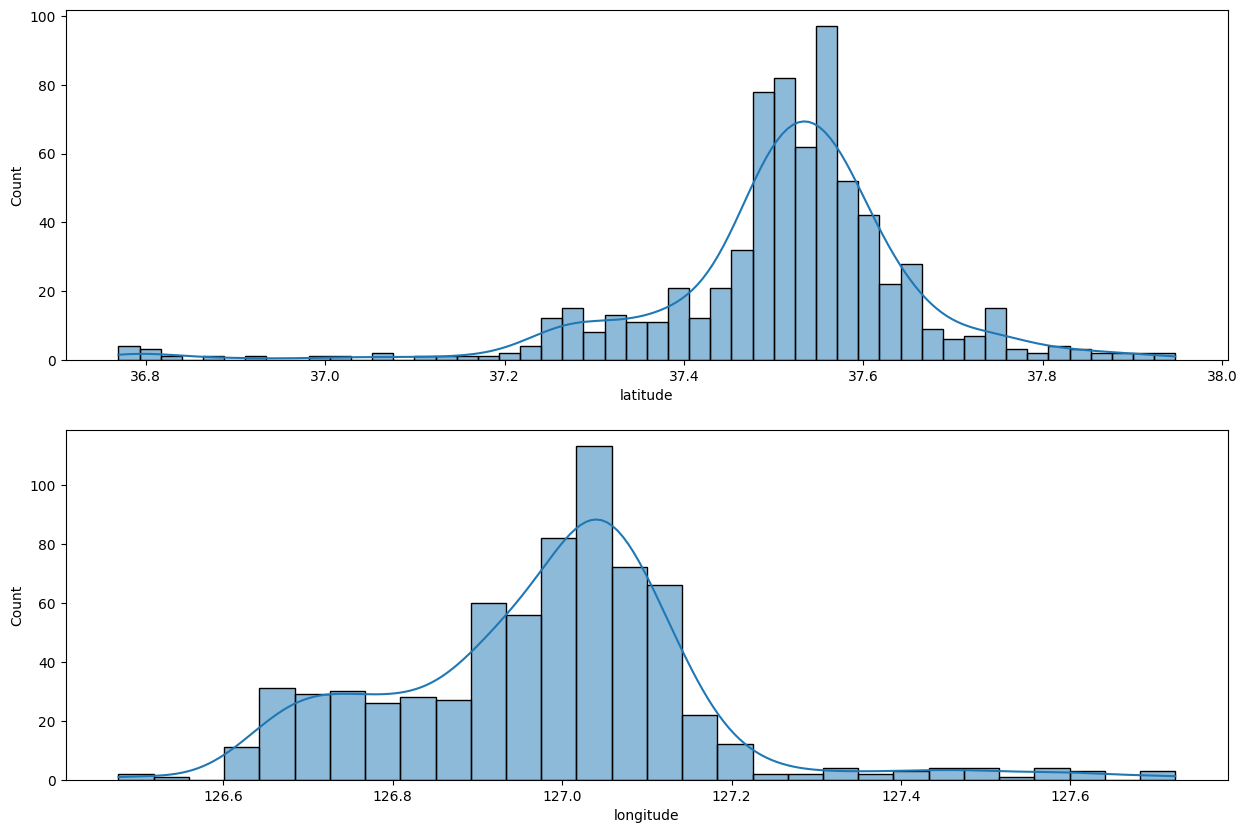

In [74]:
# 학교 위도, 경도 히스토그램 시각화
fig, axes =  plt.subplots(2, 1, figsize=(15, 10))
sns.histplot(data=subway_data, x="latitude", kde=True, ax=axes[0])
sns.histplot(data=subway_data, x="longitude", kde=True, ax=axes[1])
plt.show()

#### 2.2.4 school data

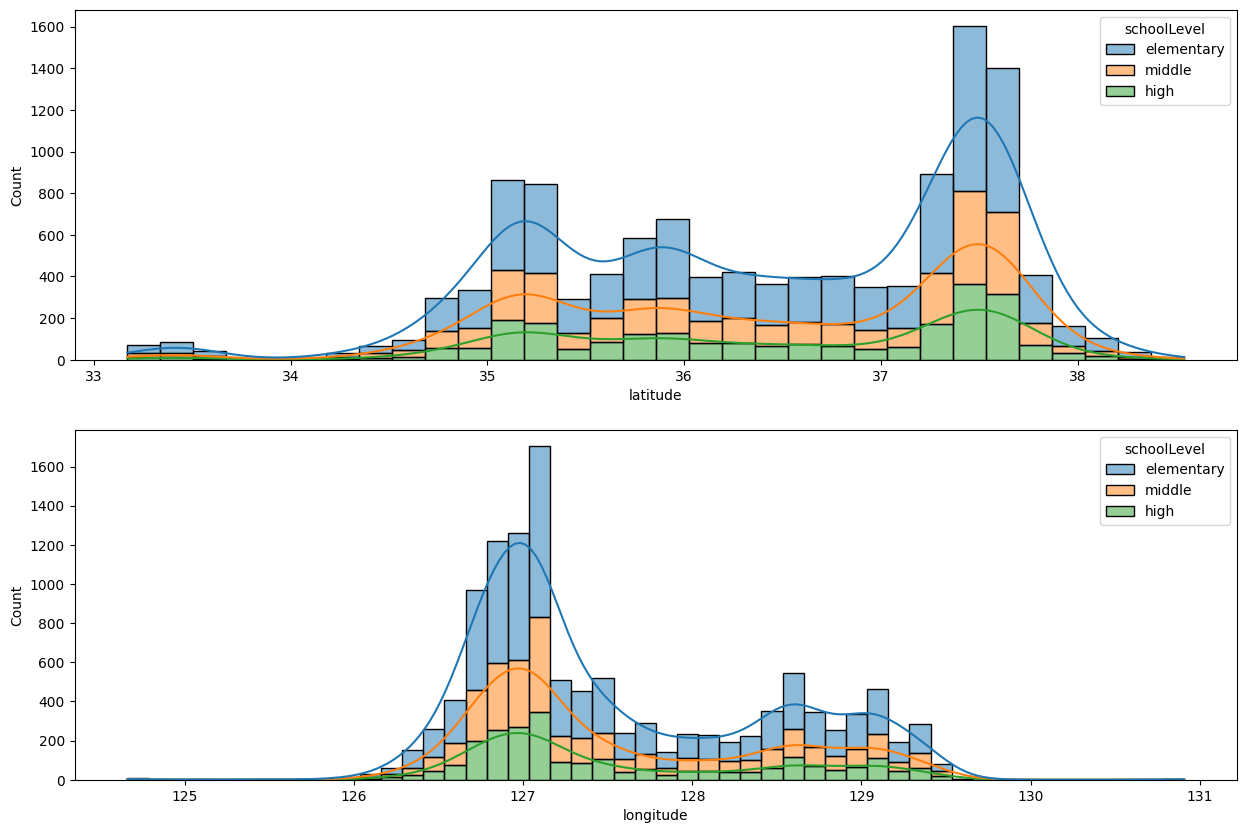

In [75]:
# 학교 레벨별 위도, 경도 히스토그램 시각화
fig, axes =  plt.subplots(2, 1, figsize=(15, 10))
sns.histplot(data=school_data, x="latitude", hue="schoolLevel", multiple="stack", kde=True, ax=axes[0])
sns.histplot(data=school_data, x="longitude", hue="schoolLevel", multiple="stack", kde=True, ax=axes[1])
plt.show()

#### 2.2.5 park data

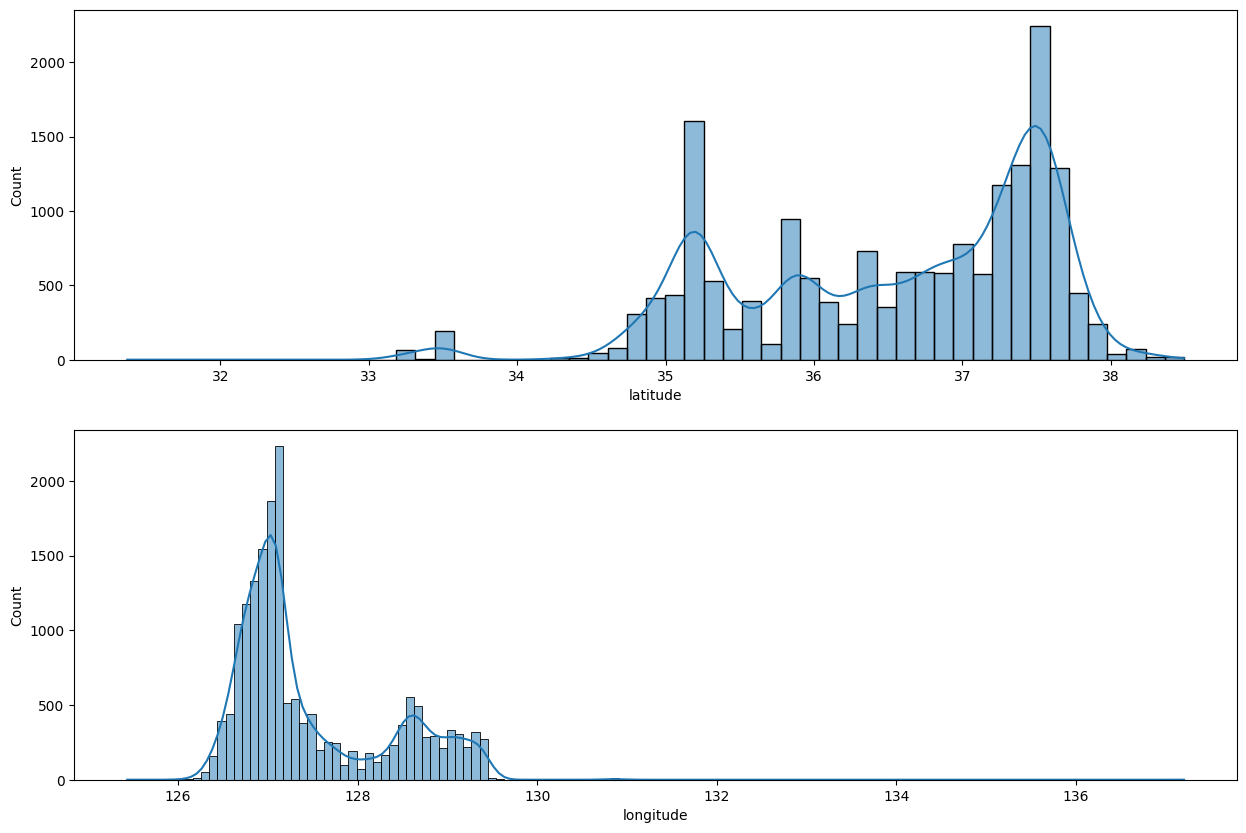

In [76]:
# 공원 위도, 경도 히스토그램 시각화
fig, axes =  plt.subplots(2, 1, figsize=(15, 10))
sns.histplot(data=park_data, x="latitude", kde=True, ax=axes[0])
sns.histplot(data=park_data, x="longitude", kde=True, ax=axes[1])
plt.show()

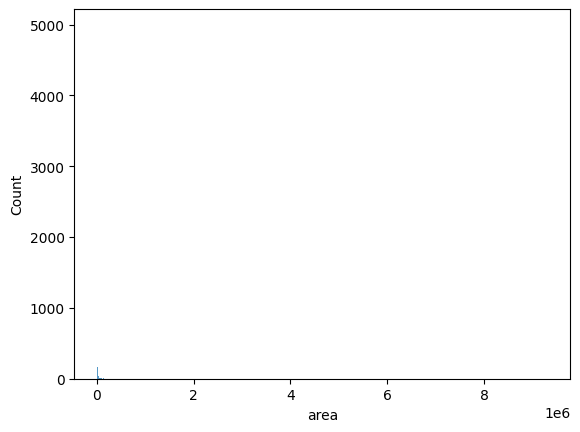

In [77]:
# 공원 면적 히스토그램 시각화
# fig, axes =  plt.subplots(figsize=(15, 5))
sns.histplot(data=park_data, x="area")
plt.show()

### [Bivariate]
### 2.3 Scatter Plot

In [78]:
# # train data 산점도 시각화 (인덱스 제외)
# fig, axes =  plt.subplots(3, 3, figsize=(15, 15))

# for idx, col in enumerate(train_data.drop(columns=["index", "contract_type"])):
#     sns.scatterplot(data=train_data.drop(columns=["index", "contract_type"]), x=col, y="deposit",
#             #    hue=train_data["contract_type"], # 계약 유형별 산점도가 보고싶은 경우
#                ax=axes[idx//3, idx%3])
    
#     if idx // 3 != 0:
#         axes[idx//3, idx%3].set_ylabel("")

# plt.show()

### 2.4 Lineplot

#### (계약 연월 순) 전세가, 금리 선 그래프 시각화

In [79]:
# 계약연월 int -> date 타입으로 변환
train_data_copy = train_data.copy()
interest_data_copy = interest_data.copy()

train_data_copy["contract_year_month"] = pd.to_datetime(train_data_copy["contract_year_month"], format="%Y%m")
interest_data_copy["year_month"] = pd.to_datetime(interest_data_copy["year_month"], format="%Y%m")

# 계약 연월별 평균 전세가, 금리 데이터프레임 생성
monthly_avg_deposit = train_data_copy.groupby("contract_year_month").agg({"deposit": "mean"}).reset_index()
monthly_avg_interest = interest_data_copy.groupby("year_month").agg({"interest_rate": "mean"}).reset_index()

# 계약 연월 기준으로 두 데이터프레임 병합
monthly_avg = monthly_avg_deposit.merge(monthly_avg_interest, left_on="contract_year_month", right_on="year_month", how="left")
monthly_avg.drop(columns=['year_month'], inplace=True)
monthly_avg.head()

,contract_year_month,deposit,interest_rate
0,2019-04-01,30447.425958,1.85
1,2019-05-01,31132.991601,1.85
2,2019-06-01,31111.287554,1.78
3,2019-07-01,31621.427691,1.68
4,2019-08-01,31712.702769,1.52


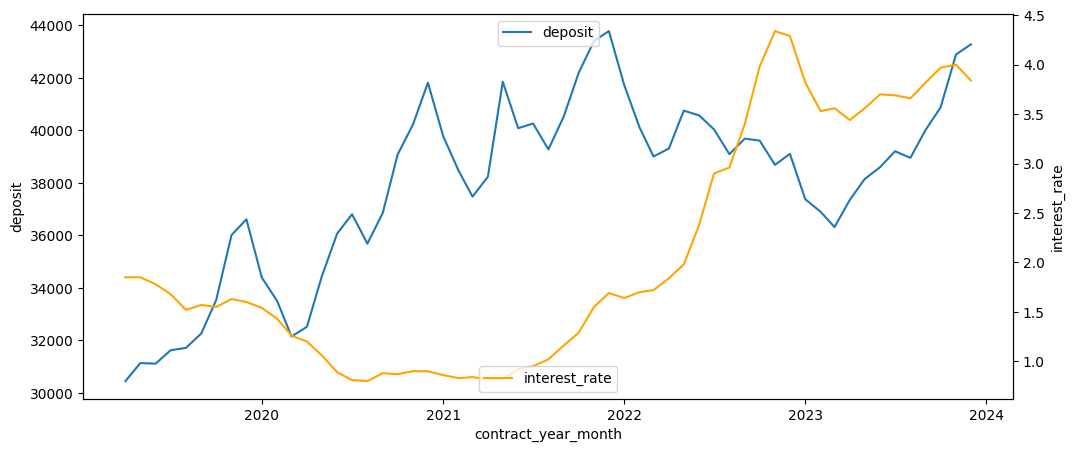

In [80]:
# 계약 연월에 따른 (평균) 전세가, 금리 시계열 데이터 시각화
fig, ax =  plt.subplots(figsize=(12, 5))
sns.lineplot(data=monthly_avg, x="contract_year_month", y="deposit", label="deposit")
plt.legend(loc="upper center")
plt.twinx()
sns.lineplot(data=monthly_avg, x="contract_year_month", y="interest_rate", color="orange", label="interest_rate")

plt.legend(loc="lower center")
plt.show()

### 2.5 Heatmap

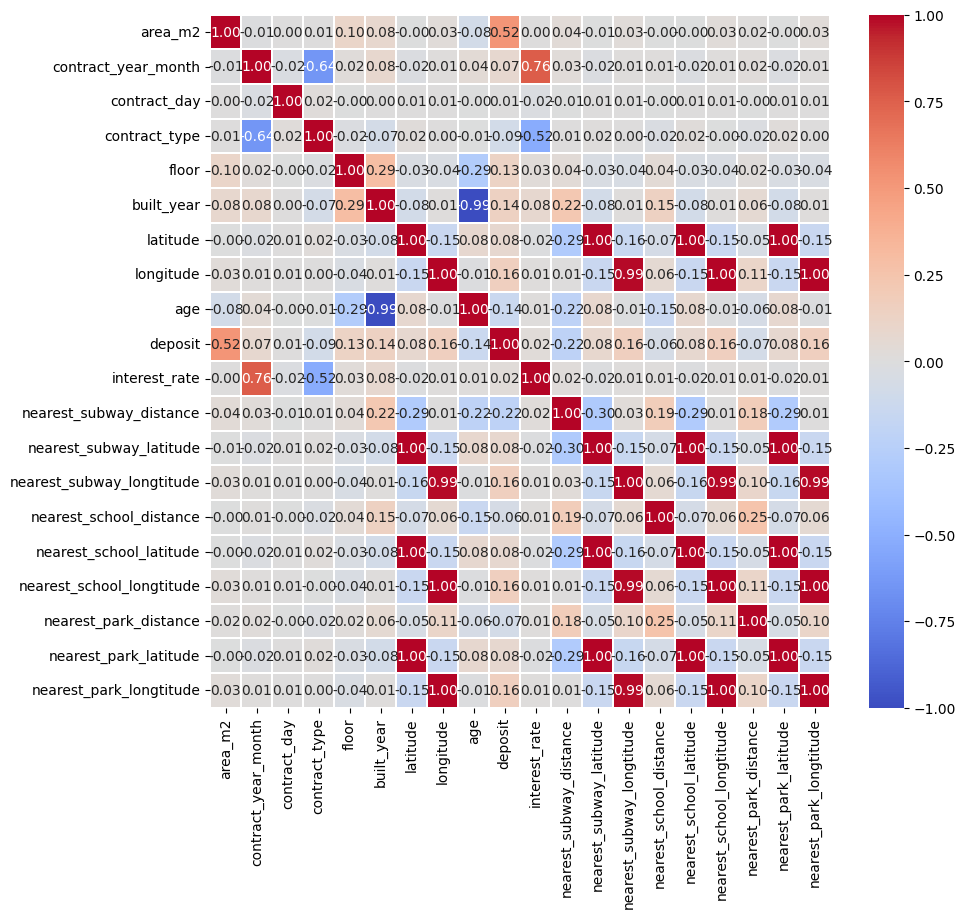

In [81]:
# train data 변수별 상관행렬(히트맵) 시각화
fig, ax = plt.subplots(figsize=(10, 9))
sns.heatmap(train_data.drop(columns="index").corr(), ax=ax,
            vmin=-1, vmax=1, center=0,
            cmap="coolwarm",
            annot=True, fmt=".2f",
            linewidth=0.1,
           )
plt.show()

## 3. Clustering (미완)

# Feature Engineering

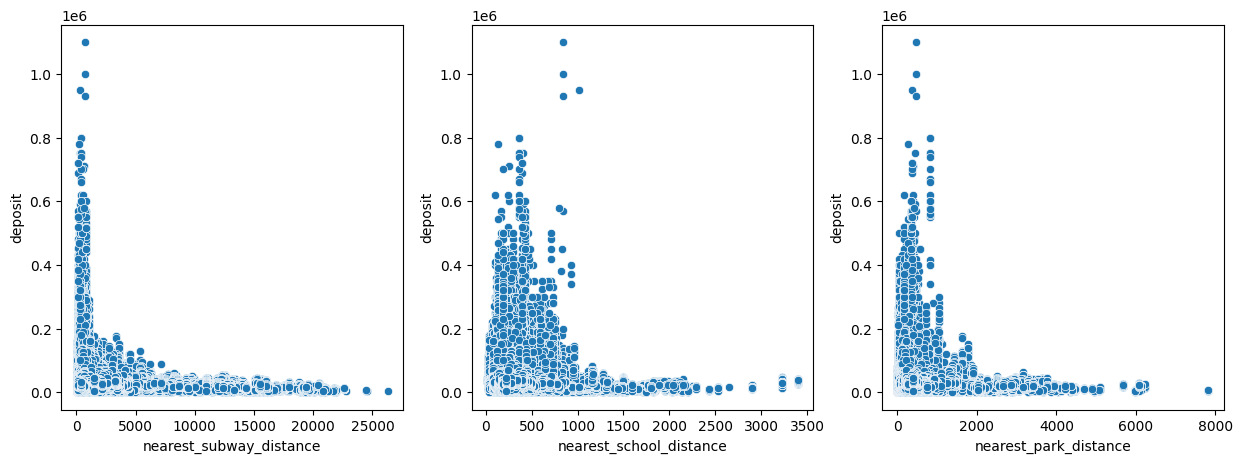

In [82]:
# 공공장소 최단거리-전세가 산점도 시각화 (train data)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.scatterplot(x="nearest_subway_distance", y="deposit", data=train_data, ax=axes[0])
sns.scatterplot(x="nearest_school_distance", y="deposit", data=train_data, ax=axes[1])
sns.scatterplot(x="nearest_park_distance", y="deposit", data=train_data, ax=axes[2])
plt.show()

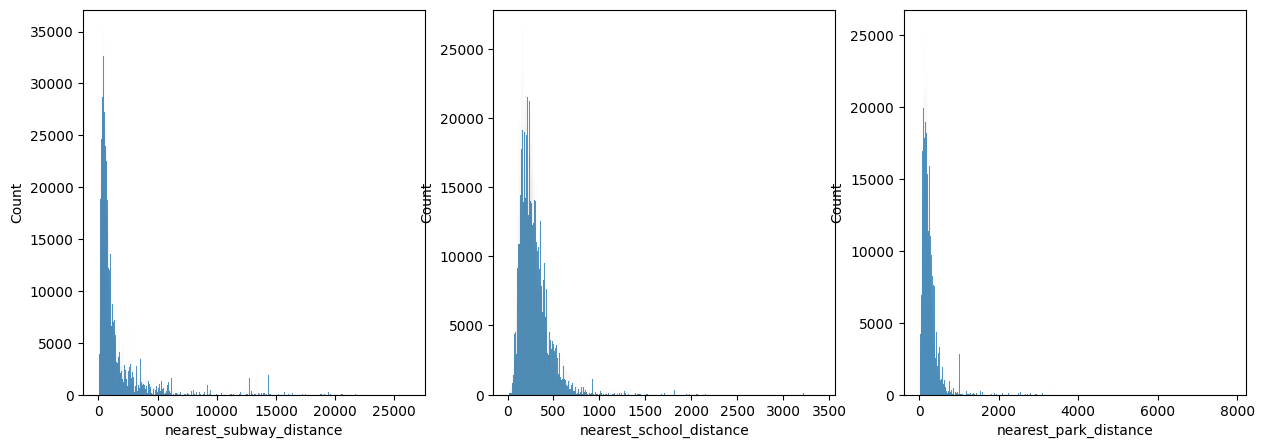

In [83]:
# 공공장소 최단거리 히스토그램 시각화 (train data)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(x="nearest_subway_distance", data=train_data, ax=axes[0])
sns.histplot(x="nearest_school_distance", data=train_data, ax=axes[1])
sns.histplot(x="nearest_park_distance", data=train_data, ax=axes[2])
plt.show()

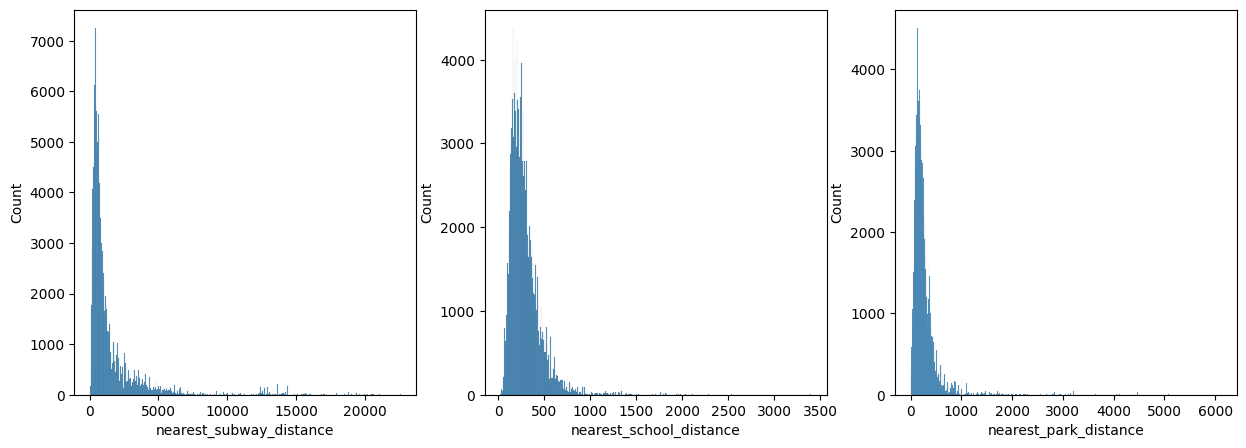

In [84]:
# 공공장소 최단거리 히스토그램 시각화 (test data)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(x="nearest_subway_distance", data=test_data, ax=axes[0])
sns.histplot(x="nearest_school_distance", data=test_data, ax=axes[1])
sns.histplot(x="nearest_park_distance", data=test_data, ax=axes[2])
plt.show()

In [85]:
# 건축 연도 2024년, 음수 층수 데이터 제거 (train data)
train_data = train_data[(train_data["built_year"] < 2024) & (train_data["floor"] >= 0)]

In [86]:
# 날짜 데이터 변환
# train_data["contract_year_month"] = pd.to_datetime(train_data["contract_year_month"], format="%Y%m")
# train_data["built_year"] = pd.to_datetime(train_data["built_year"], format="%Y")

# test_data["contract_year_month"] = pd.to_datetime(test_data["contract_year_month"], format="%Y%m")
# test_data["built_year"] = pd.to_datetime(test_data["built_year"], format="%Y")

In [87]:
# 면적, 층수, 전세가 로그 변환 (train data)
train_data["log_area_m2"] = np.log1p(train_data["area_m2"])
train_data["log_floor"] = np.log1p(train_data["floor"])
train_data["log_deposit"] = np.log1p(train_data["deposit"])
# 면적, 층수 로그 변환 (test data)
test_data["log_area_m2"] = np.log1p(test_data["area_m2"])
test_data["log_floor"] = np.log1p(test_data["floor"])

# 거리 로그 변환 (train data)
train_data["log_subway_distance"] = np.log1p(train_data["nearest_subway_distance"])
train_data["log_school_distance"] = np.log1p(train_data["nearest_school_distance"])
train_data["log_park_distance"] = np.log1p(train_data["nearest_park_distance"])
# 거리 로그 변환 (test data)
test_data["log_subway_distance"] = np.log1p(test_data["nearest_subway_distance"])
test_data["log_school_distance"] = np.log1p(test_data["nearest_school_distance"])
test_data["log_park_distance"] = np.log1p(test_data["nearest_park_distance"])

/tmp/ipykernel_707549/3846195033.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["log_area_m2"] = np.log1p(train_data["area_m2"])
/tmp/ipykernel_707549/3846195033.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["log_floor"] = np.log1p(train_data["floor"])
/tmp/ipykernel_707549/3846195033.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [88]:
# 학습에 사용할 feautre 선택
cols = ["log_area_m2", "log_floor", "log_subway_distance", "log_school_distance", "log_park_distance", "contract_year_month", "built_year", "interest_rate", "latitude", "longitude"]
X = train_data[cols]
y = train_data["log_deposit"]
X_test = test_data[cols]

# Model Training

In [89]:
# 모델 객체 생성
model = XGBRegressor(tree_method="hist", device="cuda", random_state=42)
# model.get_params()
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

## Cross Validation

In [90]:
# k-fold 교차 검증 객체 생성
kfold = KFold(n_splits=5)

# k-fold 교차 검증으로 모델 예측 및 평가
scores = []
for train_idx, valid_idx in kfold.split(X):
    X_train, X_valid = X[train_idx], X[valid_idx]
    y_train, y_valid = y[train_idx], y[valid_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    y_pred = np.expm1(y_pred)
    y_valid = np.expm1(y_valid)
    score = mean_absolute_error(y_valid, y_pred)
    scores.append(score)
    
print(f"average of MAE for k-fold CV = {scores.mean():.4f}")


# score = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error')
# print(f"average of MAE for k-fold CV = {-score.mean():.4f}")

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [07:52:54] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


average of MAE for k-fold CV = 0.1883


## Hyperparameter Tuning

In [91]:
# 목적함수 정의
def objective(trial: Type[optuna.trial.Trial]) -> float:
    """하이퍼파라미터셋 탐색을 최적화할 목적함수

    Args:
        trial (Type[optuna.trial.Trial]): optuna.trial.Trial 인스턴스

    Returns:
        float: 설정한 평가지표 (현재는 MAE)
    """
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "tree_method": "hist",
        "device": "cuda",
        "random_state": 42
    }
    model = XGBRegressor(**params)
    score = cross_val_score(model, X_train, np.expm1(y_train), cv=kfold, scoring="neg_mean_absolute_error")
    return -score.mean()

In [92]:
# optuna로 튜닝한 하이퍼파라미터셋, 평가지표 탐색
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=50)
best_params = study.best_params
print("Best parameters for XGBoost: ", best_params)

[I 2024-10-10 07:52:58,358] A new study created in memory with name: no-name-65c7de03-6fd4-4dba-bc68-1b0afae62db0
[I 2024-10-10 07:53:05,755] Trial 0 finished with value: 0.17449864524167702 and parameters: {'n_estimators': 144, 'learning_rate': 0.19063571821788408, 'max_depth': 8, 'subsample': 0.7993292420985183}. Best is trial 0 with value: 0.17449864524167702.
[I 2024-10-10 07:53:09,618] Trial 1 finished with value: 0.30093401885840815 and parameters: {'n_estimators': 89, 'learning_rate': 0.039638958863878505, 'max_depth': 3, 'subsample': 0.9330880728874675}. Best is trial 0 with value: 0.17449864524167702.
[I 2024-10-10 07:53:14,527] Trial 2 finished with value: 0.2103260867400875 and parameters: {'n_estimators': 200, 'learning_rate': 0.14453378978124864, 'max_depth': 3, 'subsample': 0.9849549260809971}. Best is trial 0 with value: 0.17449864524167702.
[I 2024-10-10 07:53:20,516] Trial 3 finished with value: 0.21619240542794818 and parameters: {'n_estimators': 258, 'learning_rate':

Best parameters for XGBoost:  {'n_estimators': 287, 'learning_rate': 0.09993219107638701, 'max_depth': 10, 'subsample': 0.8198990965633673}


# Inference

In [93]:
# 모델 추론
best_model = XGBRegressor(
    **best_params,
    # tree_method="hist",
    # device="cuda", # 현재 두 옵션 활성화하면 predict에서 error 발생
    random_state=42
)
best_model.fit(X_train, y_train)
y_pred_log = best_model.predict(X_test)
y_pred = np.expm1(y_pred_log) # 지수변환 (로그변환의 역변환)

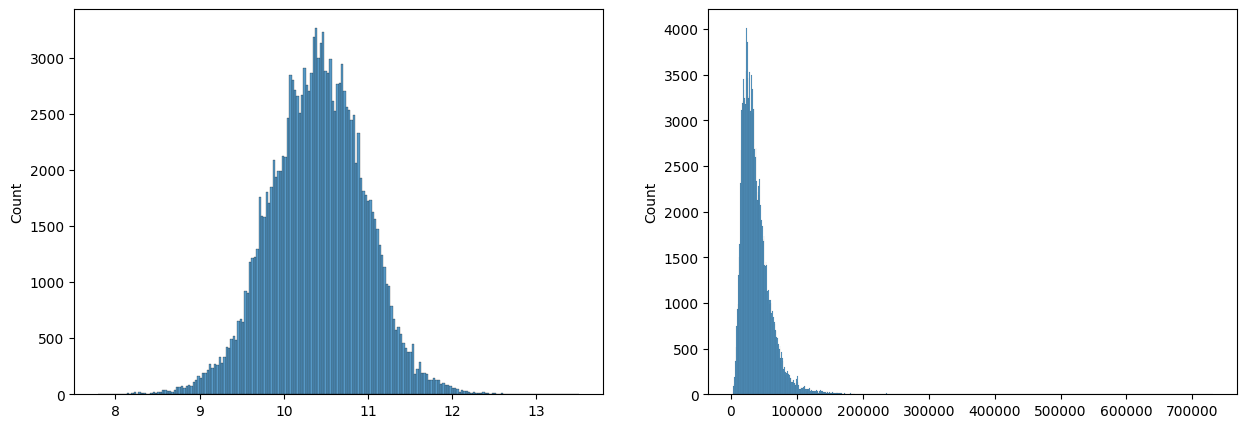

In [94]:
# 지수변환 전/후 예측값 히스토그램 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(y_pred_log, ax=axes[0])
sns.histplot(y_pred, ax=axes[1])
plt.show()

# Outut Files Save

In [95]:
sample_submission["deposit"] = y_pred
sample_submission.to_csv("output.csv", index=False)